# Codebook Overview

I have merged data from Box Office Mojo, IMDB, and TMDB to create a dataset for modeling. I first aggregated the Box Office Mojo Data (which was my fact table) and sorted it by movies and kept the first 7-day revenue for each movie as that is what we are trying to predict. The dataset initially had about 5000 movies.
But before merging it with TMDB data I filtered my dataset to keep more relevant films as we are trying to predict a major blockbuster, and the presence of many small indie films in the model can be noisy. I collected the top 160 movies per year based on revenue from TMDB and then furthered filtered them to only keep movies that played in at least 1000 theatres and had a minimum budget of 100,000 USD. My final refined dataset had around 1700 different movies (I tried to include mostly big budget movies with big releases as my end goal is to predict Avatar 3’s revenue). I included a theoretical overview section to explain my approach to feature engineering. Also I discussed the reasons for taking data from 2009-2025 in the dataset overview section (Includes factors like the rise of streaming, release of Avatar 1 in 2009 and so on).

This codebook includes:

* Theoretical Framework
* Aggregating the fact table
* Connecting it to tmdb data
* Exploratory Data Analysis
* Feature engineering

# Installing Dependencies

In [1]:
# Installing all required libraries just to be sure
import sys, subprocess; subprocess.check_call([sys.executable, "-m", "pip", "install", "numpy", "pandas", "matplotlib", "seaborn", "wordcloud", "statsmodels", "python-dateutil", "scikit-learn"])

0

In [2]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import datetime
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta, MO, TH
from sklearn.preprocessing import MultiLabelBinarizer

# Theoretical Framework

Before diving into the code, I want to establish a theoretical framework that will guide my feature engineering and modeling strategies. You can disregard this section if the thoery behind my approach is not relevant for you. Here I will be discussing how I plan on **thinking** during feature engineering.

## Bias-Variance Tradeoff

The central challenge in supervised learning is minimizing the total error, which consists of Bias, Variance, and Irreducible Error. Not being mindful may lead to underfitting or overfitting.

* Underfitting: This happens when the model is too simple to capture the underlying patterns in the data. For example, predicting box office revenue based only on "Budget" would likely have high bias, as it ignores critical factors like marketing, IP (franchise status), and competition.

* Overfitting: Occurs when the model is too complex and learns the "noise" in the training data rather than the signal. An example would be a decision tree that creates a specific rule for every unique director or every specific release date. Such a model would perform perfectly on training data but fail to generalize to new movies (like Avatar 3)

**To balance this, we will avoid using raw high-cardinality identifiers (like director_name strings) directly. Instead, we will engineer features that generalize well, such as director_avg_gross (Star Power) or is_holiday_release, allowing the model to learn patterns rather than memorizing specific names.**

## The Curse of Dimenstionality

This phenomenon refers to the exponential increase in data sparsity as the number of features (dimensions) grows.

* Our datasets contain categorical features with massive cardinality: Cast (thousands of actors), Production Companies, etc.

**Mitigation Strategy:** We cannot One-Hot Encode every actor. We will apply dimensionality reduction techniques such as:

* Feature Selection: Keeping only the top 5–10 billed actors.

* Frequency Encoding: Grouping rare production companies into an "Other" category.

## Multicollinearity

Multicollinearity occurs when independent variables in a regression model are highly correlated with one another. And it can render the interpretability of the model unstable.

* To mitigate this, we will keep an eye on correlated features and be especially wary to reduce one of the columns after one hot encoding (As the information of n columns is already implied if we have n-1 dummy encoded columns in our model)

## Data Integrity and Leakage

Data leakage is the most critical risk in predictive modeling, occurring when the training data contains information that would not be available at the time of prediction.

* A model trained on leaked data will look deceptively accurate during testing but will fail in production because the "leaked" feature won't exist yet for a future movie.

**Application to Project:**

* Temporal Leakage: We must ensure that "Star Power" is calculated using only movies released before the target movie. Using 2024 popularity scores to predict 2010 box office results is a form of leakage (hindsight bias).

* Feature Leakage: We cannot use Vote Count or Popularity (from TMDB) if those metrics are derived from post-release user activity.

* Mitigation Strategy: We will rigorously validate that all input features (e.g., Budget, Genre, Prequel Performance) are known prior to the movie's release.

# Loading the Data

Use the files in the link attached if you wish to run the codebook

[Link to the files](https://drive.google.com/drive/folders/1svwQNAyIHUnYaGMEYpYiZ3YB_Djez6pH)

In [3]:
# AUTO-INSTALL GDOWN
try:
    import gdown
except ImportError:
    print("Installing gdown...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "gdown"])
    import gdown

files = {
    "fact_table.csv":   "https://drive.google.com/file/d/19kPMjHRC7nlUrl41NPE01nuN-LqCgP1k/view?usp=drive_link",
    "tmdb_dataset.csv": "https://drive.google.com/file/d/1MGNWwiXADdNYUIVfMOEr62DouvJ5bxyK/view?usp=drive_link"
}

# DOWNLOAD LOOP
print("Checking for datasets...")
for filename, drive_link in files.items():
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")

        # Robust ID extraction (handles standard share links)
        try:
            file_id = drive_link.split('/d/')[1].split('/')[0]
            url = f'https://drive.google.com/uc?id={file_id}'
            gdown.download(url, filename, quiet=False)
        except IndexError:
            print(f"❌ Error: Invalid link for {filename}. Make sure it is a standard Drive share link.")
    else:
        print(f"Found {filename} locally.")

# LOAD DATAFRAMES

BoxOffice = pd.read_csv("fact_table.csv")
print(f"✅ Successfully loaded 'BoxOffice' DataFrame. Shape: {BoxOffice.shape}")

# Note: Renamed file locally to remove spaces/parentheses for safer handling
TMDB = pd.read_csv("tmdb_dataset.csv")
print(f"✅ Successfully loaded 'TMDB' DataFrame. Shape: {TMDB.shape}")

Checking for datasets...


Downloading...
From: https://drive.google.com/uc?id=19kPMjHRC7nlUrl41NPE01nuN-LqCgP1k
To: /content/fact_table.csv
100%|██████████| 34.3M/34.3M [00:00<00:00, 48.5MB/s]


Downloading...
From: https://drive.google.com/uc?id=1MGNWwiXADdNYUIVfMOEr62DouvJ5bxyK
To: /content/tmdb_dataset.csv
100%|██████████| 1.24M/1.24M [00:00<00:00, 44.7MB/s]


✅ Successfully loaded 'BoxOffice' DataFrame. Shape: (256140, 13)
✅ Successfully loaded 'TMDB' DataFrame. Shape: (2917, 25)


# Box Office Mojo Data Overview

* The Box Office Mojo dataset serves as the foundational "Fact Table" for the project, capturing the granular daily financial performance of films released between 2009 and 2025. By scraping daily charts, this dataset provides high-frequency time-series variables including Daily Gross, Theater Counts, Per-Theater Averages, and Cumulative Revenue.

* We will merge this with our TMDB dataset to prepare the data for modeling.

In [4]:
BoxOffice.head()

,Release,Daily,Theaters,Avg,To Date,Distributor,date,tconst,primaryTitle,isAdult,startYear,runtimeMinutes,genres
0,Marley & Me,9956212,3480.0,2860.0,82400283.0,Twentieth Century Fox,2009-01-01,tt0822832,Marley & Me,0,2008,115.0,"Drama,Family"
1,Bedtime Stories,8336917,3681.0,2264.0,65037829.0,Walt Disney Studios Motion Pictures,2009-01-01,tt0960731,Bedtime Stories,0,2008,99.0,"Adventure,Comedy,Family"
2,The Curious Case of Benjamin Button,7939690,2988.0,2657.0,60605838.0,Paramount Pictures,2009-01-01,tt0421715,The Curious Case of Benjamin Button,0,2008,166.0,"Drama,Fantasy,Romance"
3,Valkyrie,5747446,2711.0,2120.0,46649304.0,United Artists,2009-01-01,tt0985699,Valkyrie,0,2008,121.0,"Drama,History,Thriller"
4,Yes Man,5567221,3434.0,1621.0,65596911.0,Warner Bros.,2009-01-01,tt1068680,Yes Man,0,2008,104.0,"Comedy,Romance"


In [5]:
BoxOffice.columns

Index(['Release', 'Daily', 'Theaters', 'Avg', 'To Date', 'Distributor', 'date',
       'tconst', 'primaryTitle', 'isAdult', 'startYear', 'runtimeMinutes',
       'genres'],
      dtype='object')

# TMDB Data Overview

* The TMDB dataset contains data for the years 2005–2025, **specifically targeting the Top 160 Highest-Grossing Movies of each year** (8 API pages × 20 results) to ensure the inclusion of statistically significant blockbusters like Avatar and The Avengers while excluding low-budget noise.

* The time horizon we will primarily focus on is 2009–2025 (The 2005 - 2008 data was taken to handle potential mismatches in release dates in the 2 files). It was selected to capture the complete lifecycle of the modern box office ecosystem, specifically isolating the era defined by the rise of Digital 3D Cinema (beginning with Avatar in late 2009) and the structural disruption of the Streaming Era. The Avatar franchise started in 2009 so it will further help us create features using data from prequels.

* This dataset enriches the core financial data with critical missing variables, most notably Production Budget, and adds granular metadata such as Franchise/Collection IDs (vital for sequel prediction), Star Power Metrics (Director/Actor Popularity), MPAA Ratings, and flattened lists of Genres and Keywords.

* A strict post-processing filter was applied to remove records with $0 budgets, ensuring the model trains exclusively on complete financial profiles suitable for predicting high-stakes theatrical releases.

* We will further filter it later on to include only films with over 100,000 USD budget and 100 theatres on opening day as we are trying to predict a major release like Avatar: Fire and Ash. Increasing the size of the dataset using noisy films may only harm our model.

In [6]:
TMDB.head()

,id,imdb_id,title,release_date,budget,revenue,runtime,mpaa_rating,collection_name,collection_id,...,production_companies,main_production_company,director,director_id,director_popularity,top_cast,main_actor_name,main_actor_id,main_actor_popularity,cast_popularity_sum
0,25,tt0418763,Jarhead,2005-11-04,72000000,97076152,123,R,Jarhead Collection,285564.0,...,"Red Wagon Entertainment, Neal Street Productions",Red Wagon Entertainment,Sam Mendes,39.0,1.7009,"Jake Gyllenhaal, Jamie Foxx, Peter Sarsgaard, ...",Jake Gyllenhaal,131.0,8.1250,13.3480
1,35,tt0462538,The Simpsons Movie,2007-07-25,75000000,527068851,87,PG-13,The Simpsons Movie Collection,1554359.0,...,"Gracie Films, 20th Century Fox",Gracie Films,David Silverman,197.0,0.3323,"Dan Castellaneta, Julie Kavner, Nancy Cartwrig...",Dan Castellaneta,198.0,2.0641,4.8736
2,58,tt0383574,Pirates of the Caribbean: Dead Man's Chest,2006-07-06,200000000,1066179747,151,PG-13,Pirates of the Caribbean Collection,295.0,...,"Walt Disney Pictures, Jerry Bruckheimer Films,...",Walt Disney Pictures,Gore Verbinski,1704.0,1.8501,"Johnny Depp, Orlando Bloom, Keira Knightley, S...",Johnny Depp,85.0,6.4154,16.5234
3,59,tt0399146,A History of Violence,2005-09-23,32000000,61477797,96,R,NaN,NaN,...,"New Line Cinema, BenderSpink, Media I! Filmpro...",New Line Cinema,David Cronenberg,224.0,1.0678,"Viggo Mortensen, Maria Bello, Ed Harris, Willi...",Viggo Mortensen,110.0,3.0771,11.2716
4,69,tt0358273,Walk the Line,2005-09-13,28000000,186800000,136,PG-13,NaN,NaN,...,"Mars Media Beteiligungs, Tree Line Films, Catf...",Mars Media Beteiligungs,James Mangold,366.0,0.8014,"Joaquin Phoenix, Reese Witherspoon, Ginnifer G...",Joaquin Phoenix,73421.0,3.7471,14.3734


In [7]:
TMDB.columns

Index(['id', 'imdb_id', 'title', 'release_date', 'budget', 'revenue',
       'runtime', 'mpaa_rating', 'collection_name', 'collection_id',
       'vote_average', 'vote_count', 'popularity', 'genres', 'keywords',
       'production_companies', 'main_production_company', 'director',
       'director_id', 'director_popularity', 'top_cast', 'main_actor_name',
       'main_actor_id', 'main_actor_popularity', 'cast_popularity_sum'],
      dtype='object')

# Aggregating BoxOfficeMojo Data

We aggregate the fact table first and sort it by movies and find their first week revenue before merging it with TMDB data.

In [8]:
#  1. Sort the data to ensure chronological order for each movie
# This is essential for the .head(7) aggregation to work correctly
print("Sorting data by movie and date...")
BoxOffice.sort_values(by=['tconst', 'date'], inplace=True)

print("Starting aggregation to create per-movie dataset...")

#  2. Define the aggregation operations
aggregations = {
    'primaryTitle': 'first',            # Get the first 'primaryTitle' (movie title)
    'Daily': lambda x: x.head(7).sum(), # Sum the first 7 days of 'Daily'
    'Distributor': 'first',             # Get the first 'Distributor' entry
    'runtimeMinutes': 'first',          # Get the first 'runtimeMinutes' entry
    'genres': 'first',                  # Get the first 'genres' entry
    'Theaters': 'first',                # Get the opening day 'Theaters' count
    'date': 'first',                    # Get the first 'date' (release date)
    'startYear': 'first'                # Get the 'startYear'
}

#  3. Group by 'tconst' and apply the aggregations ---
# .agg() will perform all the operations at once
df_BoxOffice = BoxOffice.groupby('tconst').agg(aggregations)

#  4. Clean up the resulting DataFrame

# Rename the 'Daily' column to our target variable name
df_BoxOffice.rename(columns={'Daily': 'first_week_revenue'}, inplace=True)

# Renaming date as release date
df_BoxOffice.rename(columns={'date': 'release_date'}, inplace=True)

# Keep 'tconst' as a column
df_BoxOffice.reset_index(inplace=True)

print('Done')

Sorting data by movie and date...
Starting aggregation to create per-movie dataset...
Done


In [9]:
df_BoxOffice

,tconst,primaryTitle,first_week_revenue,Distributor,runtimeMinutes,genres,Theaters,release_date,startYear
0,tt0100275,The Wandering Soap Opera,944,The Cinema Guild,80.0,"Comedy,Drama,Fantasy",1.0,2019-05-17,2017
1,tt0293429,Mortal Kombat,27530000,Warner Bros.,110.0,"Action,Adventure,Fantasy",3073.0,2021-04-23,2021
2,tt0315642,Wazir,715211,Reliance Big Pictures,103.0,"Action,Crime,Drama",109.0,2016-01-08,2016
3,tt0327597,Coraline,20235921,Focus Features,100.0,"Animation,Drama,Family",2299.0,2009-02-06,2009
4,tt0327785,The Killer's Game,3826997,Lionsgate,104.0,"Action,Comedy,Thriller",2623.0,2024-09-13,2024
...,...,...,...,...,...,...,...,...,...
5260,tt9850064,Children of the Sea,81237,Fathom Events,111.0,"Adventure,Animation,Fantasy",633.0,2021-06-13,2019
5261,tt9856680,Puffs: Filmed Live Off Broadway,464483,Fathom Events,118.0,"Adventure,Comedy",687.0,2018-05-09,2018
5262,tt9883832,Moonage Daydream,1678526,Neon,135.0,"Biography,Documentary,History",170.0,2022-09-16,2022
5263,tt9883996,Dream Horse,1087592,Bleecker Street Media,113.0,"Biography,Comedy,Drama",1254.0,2021-05-21,2020


We run a small sanity check and the values check out

In [10]:
avatar_movies_boxoffice = df_BoxOffice[df_BoxOffice['primaryTitle'].str.contains('Avatar', case=False, na=False)]

avatar_movies_boxoffice

,tconst,primaryTitle,first_week_revenue,Distributor,runtimeMinutes,genres,Theaters,release_date,startYear
117,tt0499549,Avatar,137094051,Twentieth Century Fox,162.0,"Action,Adventure,Fantasy",3452.0,2009-12-18,2009
1781,tt1630029,Avatar: The Way of Water,197681686,20th Century Studios,192.0,"Action,Adventure,Fantasy",4202.0,2022-12-16,2022


We see a small discrepancy in the way the distributor name is spelled which we will fix later on.

# Merging with TMDB Data

We now merge the aggregated Box Office Mojo data with TMDB data. This merge will make our dataset smaller as we want our model to focus on theatrical releases that can help predict performance of blockbusters like Avatar (Our TMDB data already contains top 160 revenue generating films from each year). After the merge, we will be able to eliminate most of the noisy data that may not be helpful in predicting a blockbuster franchise like Avatar.

In [11]:
TMDB.columns

Index(['id', 'imdb_id', 'title', 'release_date', 'budget', 'revenue',
       'runtime', 'mpaa_rating', 'collection_name', 'collection_id',
       'vote_average', 'vote_count', 'popularity', 'genres', 'keywords',
       'production_companies', 'main_production_company', 'director',
       'director_id', 'director_popularity', 'top_cast', 'main_actor_name',
       'main_actor_id', 'main_actor_popularity', 'cast_popularity_sum'],
      dtype='object')

* id which has the tmdb id is not necessary going forward
* We need to merge on imdb_id so we keep that
* We keep title for sanity check (Will remove afterwards)
* Release date in BoxOfficeMojo is more accurate as that is when it started screening in the domestic market
* Revenue is not necessary as we will be using BoxOfficeMojo data for that
* Genres is also already available in BoxOfficeMojo data
* We remove the vote data as they can't be used in a predictive model
* We keep all the reamaining columns for now to help with feature engineering

In [12]:
columns_to_keep_from_tmdb = [
    # Key
    'imdb_id',
    'title',

    # Features
    'budget',
    'runtime',
    'mpaa_rating',
    'collection_name',
    'collection_id',
    'keywords',
    'production_companies',
    'main_production_company',
    'director',
    'director_id',
    'director_popularity',
    'top_cast',
    'main_actor_name',
    'main_actor_id',
    'main_actor_popularity',
    'cast_popularity_sum' ]


# Create your new, clean DataFrame
TMDB_clean = TMDB[columns_to_keep_from_tmdb].copy()

In [13]:
df_BoxOffice.columns

Index(['tconst', 'primaryTitle', 'first_week_revenue', 'Distributor',
       'runtimeMinutes', 'genres', 'Theaters', 'release_date', 'startYear'],
      dtype='object')

* We will be merging using tconst
* We keep all the columns here as we already cleaned our fact table in a previous codebook
* We will remove a few redundant columns like startYear during feature engineering

## The Merge

In [14]:
# We merge on TMDB's 'imdb_id' and BoxOffice's 'tconst'
df_features = pd.merge(
    TMDB_clean,
    df_BoxOffice,
    left_on='imdb_id',  # Key from TMDB
    right_on='tconst',  # Key from BoxOffice
    how='inner'         # This keeps *only* movies that exist in both files
)

# Clean up redundant 'tconst' column
df_features = df_features.drop(columns=['tconst'])

print(f"--- ✅ FINAL MERGE COMPLETE ---")
print(f"Your new master DataFrame ('df_master') has {df_features.shape[0]} movies.")

--- ✅ FINAL MERGE COMPLETE ---
Your new master DataFrame ('df_master') has 2006 movies.


In [15]:
df_features.head()

,imdb_id,title,budget,runtime,mpaa_rating,collection_name,collection_id,keywords,production_companies,main_production_company,...,main_actor_popularity,cast_popularity_sum,primaryTitle,first_week_revenue,Distributor,runtimeMinutes,genres,Theaters,release_date,startYear
0,tt0468569,The Dark Knight,185000000,152,PG-13,The Dark Knight Collection,263.0,"sadism, chaos, secret identity, crime fighter,...","Warner Bros. Pictures, Legendary Pictures, Syn...",Warner Bros. Pictures,...,6.7369,14.0535,The Dark Knight,89354,Warner Bros.,152.0,"Action,Crime,Drama",74.0,2009-01-01,2008
1,tt0458481,Sin City: A Dame to Kill For,65000000,102,R,Sin City Collection,135179.0,"detective, dystopia, dominatrix, murder, twins","Residaco, Miramax, Troublemaker Studios, Aldam...",Residaco,...,8.0406,15.9881,Sin City: A Dame to Kill For,8591561,Dimension Films,102.0,"Action,Crime,Thriller",2894.0,2014-08-22,2014
2,tt0438488,Terminator Salvation,200000000,115,PG-13,The Terminator Collection,528.0,"army, artificial intelligence (a.i.), saving t...","The Halcyon Company, Moritz Borman Productions...",The Halcyon Company,...,6.7369,11.9033,Terminator Salvation,71859503,Warner Bros.,115.0,"Action,Adventure,Sci-Fi",3480.0,2009-05-21,2009
3,tt0417741,Harry Potter and the Half-Blood Prince,250000000,153,PG,Harry Potter Collection,1241.0,"witch, dying and death, london, england, magic...","Warner Bros. Pictures, Heyday Films",Warner Bros. Pictures,...,4.6485,17.7728,Harry Potter and the Half-Blood Prince,177457914,Warner Bros.,153.0,"Action,Adventure,Family",4275.0,2009-07-15,2009
4,tt0371746,Iron Man,140000000,126,PG-13,Iron Man Collection,131292.0,"middle east, superhero, arms dealer, malibu, b...","Marvel Studios, Marvel Entertainment, Fairview...",Marvel Studios,...,7.9068,13.8673,Iron Man,192025,Paramount Pictures,126.0,"Action,Adventure,Sci-Fi",1105.0,2010-05-06,2008


* We were able to successfully merge around 85% of the movies in our TMDB dataset to our BoxOfficeMojo data. This is completely normal as Box Office Mojo tracks movies that had a theatrical release in the US and reported earnings, while TMDB tracks everything—streaming exclusives (Netflix/Hulu originals), direct-to-video movies, and international films that never played in US theaters.

* Even though we sorted by revenue while getting the TMDB dataset, there are small budget films in there that were not captured in the BoxOfficeMojo data. We can ignore these as they wouldn't be helpful in predicting a blockbuster like Avatar 3 in the first place.

## Sanity Check

In [16]:
avatar_movies_features = df_features[df_features['title'].str.contains('Avatar', case=False, na=False)]
avatar_movies_features

,imdb_id,title,budget,runtime,mpaa_rating,collection_name,collection_id,keywords,production_companies,main_production_company,...,main_actor_popularity,cast_popularity_sum,primaryTitle,first_week_revenue,Distributor,runtimeMinutes,genres,Theaters,release_date,startYear
160,tt0499549,Avatar,237000000,162,PG-13,Avatar Collection,87096.0,"paraplegic, attachment to nature, culture clas...","Dune Entertainment, Lightstorm Entertainment, ...",Dune Entertainment,...,3.801,13.376,Avatar,137094051,Twentieth Century Fox,162.0,"Action,Adventure,Fantasy",3452.0,2009-12-18,2009
544,tt1630029,Avatar: The Way of Water,350000000,192,PG-13,Avatar Collection,87096.0,"dying and death, loss of loved one, alien life...","20th Century Studios, Lightstorm Entertainment...",20th Century Studios,...,3.801,13.376,Avatar: The Way of Water,197681686,20th Century Studios,192.0,"Action,Adventure,Fantasy",4202.0,2022-12-16,2022


The avatar films are here and the values are all correct

**20th Century Studios is the new name for 20th Century Fox after its acquisition by Disney.**

We standardize it to keep only the new studio name

# Cleaning `df_features`

## Standardizing Distributor Names

We will standardize distributor names like 'Twentieth Century Fox' and '20th Century Studios' to a single entry, '20th Century Studios', to ensure consistency for later analysis and feature engineering.

In [17]:
df_features['Distributor'] = df_features['Distributor'].replace('Twentieth Century Fox', '20th Century Studios')

In [18]:
avatar_movies_features = df_features[df_features['title'].str.contains('Avatar', case=False, na=False)]
avatar_movies_features

,imdb_id,title,budget,runtime,mpaa_rating,collection_name,collection_id,keywords,production_companies,main_production_company,...,main_actor_popularity,cast_popularity_sum,primaryTitle,first_week_revenue,Distributor,runtimeMinutes,genres,Theaters,release_date,startYear
160,tt0499549,Avatar,237000000,162,PG-13,Avatar Collection,87096.0,"paraplegic, attachment to nature, culture clas...","Dune Entertainment, Lightstorm Entertainment, ...",Dune Entertainment,...,3.801,13.376,Avatar,137094051,20th Century Studios,162.0,"Action,Adventure,Fantasy",3452.0,2009-12-18,2009
544,tt1630029,Avatar: The Way of Water,350000000,192,PG-13,Avatar Collection,87096.0,"dying and death, loss of loved one, alien life...","20th Century Studios, Lightstorm Entertainment...",20th Century Studios,...,3.801,13.376,Avatar: The Way of Water,197681686,20th Century Studios,192.0,"Action,Adventure,Fantasy",4202.0,2022-12-16,2022


We have a standardized distributor name now

## Dropping Redundant Columns

In [19]:
# We remove redundant columns as the sanity check is done
columns_to_drop_from_df_features = ['title', 'runtime']
df_features = df_features.drop(columns=columns_to_drop_from_df_features, errors='ignore')
print(f"Successfully dropped {columns_to_drop_from_df_features} from df_features.")

Successfully dropped ['title', 'runtime'] from df_features.


In [20]:
df_features.head()

,imdb_id,budget,mpaa_rating,collection_name,collection_id,keywords,production_companies,main_production_company,director,director_id,...,main_actor_popularity,cast_popularity_sum,primaryTitle,first_week_revenue,Distributor,runtimeMinutes,genres,Theaters,release_date,startYear
0,tt0468569,185000000,PG-13,The Dark Knight Collection,263.0,"sadism, chaos, secret identity, crime fighter,...","Warner Bros. Pictures, Legendary Pictures, Syn...",Warner Bros. Pictures,Christopher Nolan,525.0,...,6.7369,14.0535,The Dark Knight,89354,Warner Bros.,152.0,"Action,Crime,Drama",74.0,2009-01-01,2008
1,tt0458481,65000000,R,Sin City Collection,135179.0,"detective, dystopia, dominatrix, murder, twins","Residaco, Miramax, Troublemaker Studios, Aldam...",Residaco,Frank Miller,2293.0,...,8.0406,15.9881,Sin City: A Dame to Kill For,8591561,Dimension Films,102.0,"Action,Crime,Thriller",2894.0,2014-08-22,2014
2,tt0438488,200000000,PG-13,The Terminator Collection,528.0,"army, artificial intelligence (a.i.), saving t...","The Halcyon Company, Moritz Borman Productions...",The Halcyon Company,McG,36425.0,...,6.7369,11.9033,Terminator Salvation,71859503,Warner Bros.,115.0,"Action,Adventure,Sci-Fi",3480.0,2009-05-21,2009
3,tt0417741,250000000,PG,Harry Potter Collection,1241.0,"witch, dying and death, london, england, magic...","Warner Bros. Pictures, Heyday Films",Warner Bros. Pictures,David Yates,11343.0,...,4.6485,17.7728,Harry Potter and the Half-Blood Prince,177457914,Warner Bros.,153.0,"Action,Adventure,Family",4275.0,2009-07-15,2009
4,tt0371746,140000000,PG-13,Iron Man Collection,131292.0,"middle east, superhero, arms dealer, malibu, b...","Marvel Studios, Marvel Entertainment, Fairview...",Marvel Studios,Jon Favreau,15277.0,...,7.9068,13.8673,Iron Man,192025,Paramount Pictures,126.0,"Action,Adventure,Sci-Fi",1105.0,2010-05-06,2008


## Dropping Noisy Data

We will remove movies with very low theater counts and very low budgets, as these are likely limited releases or independent films that don't fit our target demographic (blockbusters like 'Avatar').

In [21]:
print(f"Initial shape of df_features: {df_features.shape}")

# Define thresholds for 'noisy' data
min_theaters = 100  # Example: Movies released in fewer than 100 theaters
min_budget = 100000 # Example: Movies with budget less than $100,000

# Filter out noisy data
df_features_cleaned = df_features[
    (df_features['Theaters'] >= min_theaters) &
    (df_features['budget'] >= min_budget)
].copy()

print(f"Shape of df_features after dropping noisy data: {df_features_cleaned.shape}")
print(f"Number of rows dropped: {df_features.shape[0] - df_features_cleaned.shape[0]}")

# Update df_features to the cleaned version
df_features = df_features_cleaned
display(df_features.head())

Initial shape of df_features: (2006, 24)
Shape of df_features after dropping noisy data: (1739, 24)
Number of rows dropped: 267


,imdb_id,budget,mpaa_rating,collection_name,collection_id,keywords,production_companies,main_production_company,director,director_id,...,main_actor_popularity,cast_popularity_sum,primaryTitle,first_week_revenue,Distributor,runtimeMinutes,genres,Theaters,release_date,startYear
1,tt0458481,65000000,R,Sin City Collection,135179.0,"detective, dystopia, dominatrix, murder, twins","Residaco, Miramax, Troublemaker Studios, Aldam...",Residaco,Frank Miller,2293.0,...,8.0406,15.9881,Sin City: A Dame to Kill For,8591561,Dimension Films,102.0,"Action,Crime,Thriller",2894.0,2014-08-22,2014
2,tt0438488,200000000,PG-13,The Terminator Collection,528.0,"army, artificial intelligence (a.i.), saving t...","The Halcyon Company, Moritz Borman Productions...",The Halcyon Company,McG,36425.0,...,6.7369,11.9033,Terminator Salvation,71859503,Warner Bros.,115.0,"Action,Adventure,Sci-Fi",3480.0,2009-05-21,2009
3,tt0417741,250000000,PG,Harry Potter Collection,1241.0,"witch, dying and death, london, england, magic...","Warner Bros. Pictures, Heyday Films",Warner Bros. Pictures,David Yates,11343.0,...,4.6485,17.7728,Harry Potter and the Half-Blood Prince,177457914,Warner Bros.,153.0,"Action,Adventure,Family",4275.0,2009-07-15,2009
4,tt0371746,140000000,PG-13,Iron Man Collection,131292.0,"middle east, superhero, arms dealer, malibu, b...","Marvel Studios, Marvel Entertainment, Fairview...",Marvel Studios,Jon Favreau,15277.0,...,7.9068,13.8673,Iron Man,192025,Paramount Pictures,126.0,"Action,Adventure,Sci-Fi",1105.0,2010-05-06,2008
5,tt0458339,140000000,PG-13,Captain America Collection,131295.0,"new york city, nazi, superhero, world war ii, ...","Marvel Studios, Marvel Entertainment",Marvel Studios,Joe Johnston,4945.0,...,4.3772,12.1423,Captain America: The First Avenger,91867268,Paramount Pictures,124.0,"Action,Adventure,Sci-Fi",3715.0,2011-07-22,2011


We are left with 1739 films in our final dataset which we will now explore.

# Exploratory Data Analysis on `df_features`

In this section we take a deep dive into the nature of the data we have. You can skip this section if you primarily want to see feature engineering.

In [22]:
print("### DataFrame Information ###")
df_features.info()

print("\n### Descriptive Statistics for Numerical Columns ###")
display(df_features.describe())

### DataFrame Information ###
<class 'pandas.core.frame.DataFrame'>
Index: 1739 entries, 1 to 2004
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   imdb_id                  1739 non-null   object 
 1   budget                   1739 non-null   int64  
 2   mpaa_rating              1739 non-null   object 
 3   collection_name          637 non-null    object 
 4   collection_id            637 non-null    float64
 5   keywords                 1727 non-null   object 
 6   production_companies     1738 non-null   object 
 7   main_production_company  1738 non-null   object 
 8   director                 1739 non-null   object 
 9   director_id              1739 non-null   float64
 10  director_popularity      1739 non-null   float64
 11  top_cast                 1739 non-null   object 
 12  main_actor_name          1739 non-null   object 
 13  main_actor_id            1739 non-null   float64
 14 

,budget,collection_id,director_id,director_popularity,main_actor_id,main_actor_popularity,cast_popularity_sum,first_week_revenue,runtimeMinutes,Theaters,startYear
count,1.739000e+03,6.370000e+02,1.739000e+03,1739.000000,1.739000e+03,1739.000000,1739.000000,1.739000e+03,1739.000000,1739.000000,1739.000000
mean,6.368968e+07,4.344699e+05,2.869998e+05,1.264807,2.723055e+05,4.991078,12.185784,3.653210e+07,112.266820,2900.024727,2016.265670
std,6.380557e+07,4.034802e+05,5.514659e+05,1.399527,5.887406e+05,4.230017,7.099570,4.682086e+07,19.779192,1009.172666,4.959169
min,1.000000e+05,1.000000e+01,7.000000e+00,0.029700,2.000000e+00,0.040200,0.437800,3.943100e+04,63.000000,100.000000,2007.000000
25%,2.000000e+07,9.034800e+04,1.296200e+04,0.483900,5.530000e+03,2.374600,7.340700,1.098744e+07,98.000000,2502.000000,2012.000000
50%,4.000000e+07,3.448300e+05,5.641100e+04,0.901700,2.884600e+04,3.931600,10.810400,2.120654e+07,108.000000,3058.000000,2016.000000
75%,8.625000e+07,5.956930e+05,1.308875e+05,1.486250,9.248800e+04,6.303000,15.618850,4.207394e+07,123.000000,3593.000000,2020.000000
max,5.839000e+08,1.543569e+06,4.524084e+06,15.402100,4.659347e+06,75.183800,81.786200,4.738946e+08,206.000000,4735.000000,2025.000000


### Descriptive Statistics (`df_features.describe()`)

*   **`budget` and `first_week_revenue`:** Both show extremely large ranges and high standard deviations, with the mean significantly higher than the median. This indicates a highly skewed distribution, with a few blockbuster films driving up the averages and many films with much lower budgets/revenues. We will attempt to visualize this skewness going forward.
*   **`Theaters`:** The `Theaters` count also has a wide range (from 100 to over 4800), with a mean around 2800. This indicates the diversity in the scale of releases, which is likely a strong predictor of revenue.
*   **Popularity Metrics (`director_popularity`, `main_actor_popularity`, `cast_popularity_sum`):** These metrics also exhibit right-skewness, similar to budget and revenue. This suggests that a few highly popular individuals/casts exist, while the majority have lower popularity scores. These feature may have data leakage issues which might make them useless.
*   **`runtimeMinutes`:** The average runtime is around 125 minutes (2 hours 5 minutes), with a relatively small standard deviation, indicating most films fall within a typical feature film length. This could still be a useful feature, possibly with binning.

In [23]:
# Taking a look at the biggest films
top_5_budget_films = df_features.sort_values(by='budget', ascending=False).head(5)
display(top_5_budget_films)

,imdb_id,budget,mpaa_rating,collection_name,collection_id,keywords,production_companies,main_production_company,director,director_id,...,main_actor_popularity,cast_popularity_sum,primaryTitle,first_week_revenue,Distributor,runtimeMinutes,genres,Theaters,release_date,startYear
1463,tt8041270,583900000,PG-13,Jurassic Park Collection,328.0,"paleontology, giant monster, sequel, survival,...","Amblin Entertainment, Universal Pictures",Amblin Entertainment,Colin Trevorrow,930707.0,...,6.5148,15.0831,Jurassic World: Dominion,191136690,Universal Pictures,147.0,"Action,Adventure,Sci-Fi",4676.0,2022-06-10,2022
772,tt2527338,489900000,PG-13,Star Wars Collection,10.0,space opera,"Lucasfilm Ltd., Bad Robot",Lucasfilm Ltd.,J.J. Abrams,15344.0,...,1.6182,8.8995,Star Wars: Episode IX - The Rise of Skywalker,289796816,Walt Disney Studios Motion Pictures,141.0,"Action,Adventure,Fantasy",4406.0,2019-12-20,2019
1582,tt9603208,400000000,PG-13,Mission: Impossible Collection,87359.0,"mask, artificial intelligence (a.i.), diving, ...","Paramount Pictures, Skydance Media, TC Product...",Paramount Pictures,Christopher McQuarrie,9033.0,...,8.9658,15.6623,Mission: Impossible - The Final Reckoning,95318108,Paramount Pictures International,169.0,"Action,Adventure,Thriller",3857.0,2025-05-23,2025
6,tt1298650,379000000,PG-13,Pirates of the Caribbean Collection,295.0,"sea, ship, mutiny, spain, england","Walt Disney Pictures, Jerry Bruckheimer Films,...",Walt Disney Pictures,Rob Marshall,17633.0,...,6.4154,12.7235,Pirates of the Caribbean: On Stranger Tides,113595287,Walt Disney Studios Motion Pictures,136.0,"Action,Adventure,Fantasy",4155.0,2011-05-20,2011
1015,tt4154796,356000000,PG-13,The Avengers Collection,86311.0,"superhero, time travel, space travel, time mac...",Marvel Studios,Marvel Studios,Anthony Russo,19271.0,...,7.9068,17.5106,Avengers: Endgame,473894638,Walt Disney Studios Motion Pictures,181.0,"Action,Adventure,Sci-Fi",4662.0,2019-04-26,2019


In [24]:
# Biggest theatre releases
top_5_theaters_films = df_features.sort_values(by='Theaters', ascending=False).head(5)
display(top_5_theaters_films)

,imdb_id,budget,mpaa_rating,collection_name,collection_id,keywords,production_companies,main_production_company,director,director_id,...,main_actor_popularity,cast_popularity_sum,primaryTitle,first_week_revenue,Distributor,runtimeMinutes,genres,Theaters,release_date,startYear
1169,tt1745960,170000000,PG-13,Top Gun Collection,531330.0,"fighter pilot, u.s. navy, sequel, nuclear weap...","Skydance Media, Don Simpson/Jerry Bruckheimer ...",Skydance Media,Joseph Kosinski,86270.0,...,8.9658,14.4897,Top Gun: Maverick,205604011,Paramount Pictures,130.0,"Action,Drama",4735.0,2022-05-27,2022
1291,tt6105098,260000000,PG,The Lion King (Reboot) Collection,762512.0,"africa, lion, prince, redemption, musical","Walt Disney Pictures, Fairview Entertainment",Walt Disney Pictures,Jon Favreau,15277.0,...,2.2241,4.3394,The Lion King,275251534,Walt Disney Studios Motion Pictures,118.0,"Adventure,Animation,Drama",4725.0,2019-07-19,2019
1463,tt8041270,583900000,PG-13,Jurassic Park Collection,328.0,"paleontology, giant monster, sequel, survival,...","Amblin Entertainment, Universal Pictures",Amblin Entertainment,Colin Trevorrow,930707.0,...,6.5148,15.0831,Jurassic World: Dominion,191136690,Universal Pictures,147.0,"Action,Adventure,Sci-Fi",4676.0,2022-06-10,2022
1015,tt4154796,356000000,PG-13,The Avengers Collection,86311.0,"superhero, time travel, space travel, time mac...",Marvel Studios,Marvel Studios,Anthony Russo,19271.0,...,7.9068,17.5106,Avengers: Endgame,473894638,Walt Disney Studios Motion Pictures,181.0,"Action,Adventure,Sci-Fi",4662.0,2019-04-26,2019
1310,tt6320628,160000000,PG-13,Spider-Man (MCU) Collection,531241.0,"venice, italy, superhero, school trip, europe,...","Marvel Studios, Pascal Pictures, Columbia Pict...",Marvel Studios,Jon Watts,1293994.0,...,6.9307,24.1929,Spider-Man: Far from Home,195940027,Sony Pictures Releasing,129.0,"Action,Adventure,Comedy",4634.0,2019-07-02,2019


Most high budget films seem to have big theatrical releases. They include major blockbustors like Top Gun and Star Wars. However, there may be an issue with multicollinearity which we will check in the next section.

## Correlation Heatmap

We create a correlation heatmap of some of the features here

In [25]:
# Set the visual style for all plots
sns.set(style="whitegrid")

# Convert release_date to datetime objects (useful for time-based plotting later)
df_features['release_date'] = pd.to_datetime(df_features['release_date'])

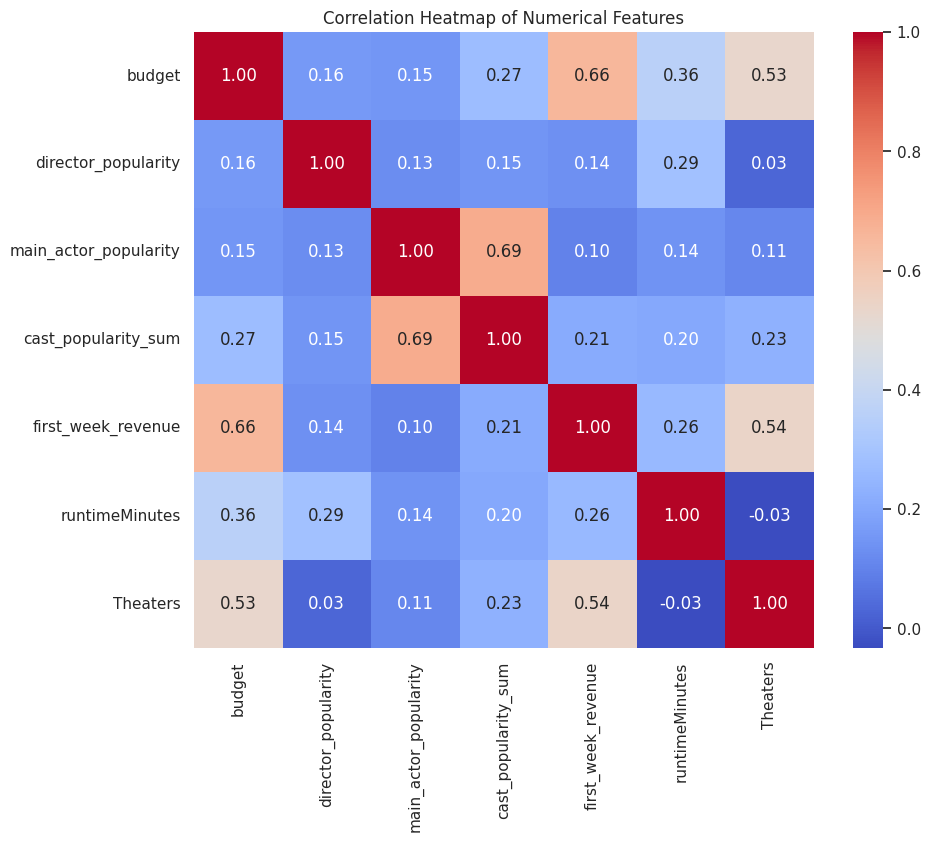

In [26]:
plt.figure(figsize=(10, 8))

# Select only numerical columns for correlation
numerical_cols = ['budget', 'director_popularity', 'main_actor_popularity',
                  'cast_popularity_sum', 'first_week_revenue',
                  'runtimeMinutes', 'Theaters']

# Calculate correlation matrix
corr_matrix = df_features[numerical_cols].corr()

# Create heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

first_week_revenue has the strongest correlation with Theaters and budget. This suggests that the width of the release (number of theaters) and the production budget are the most significant predictors of opening week success in this dataset. However, the correlations are not extremely high so we don't necessarily have to remove any columns for multicollinearity. We further use VIF to ensure our features don't have a multicollinearity issue.

### VIF for Multicollinearity

In [27]:
# 1. Select the numerical features we want to check
features = ['budget', 'director_popularity', 'main_actor_popularity',
            'cast_popularity_sum', 'runtimeMinutes', 'Theaters']

# 2. Create the feature matrix (drop NaNs as VIF can't handle them)
X = df_features[features].dropna()

# 3. Add a constant (intercept)
X = add_constant(X)

# 4. Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# 5. Show results (excluding the constant)
vif_results = vif_data[vif_data["Feature"] != "const"].sort_values(by="VIF", ascending=False)
display(vif_results)

,Feature,VIF
4,cast_popularity_sum,2.081054
3,main_actor_popularity,1.928323
1,budget,1.751980
6,Theaters,1.547147
5,runtimeMinutes,1.347725
2,director_popularity,1.103377


**VIF < 5: Generally considered low multicollinearity.**

So our features are good to go for modelling.

## Budget vs. `first_week_revenue`

We take a deeper look at some of the strong features we found to understand how they work further.

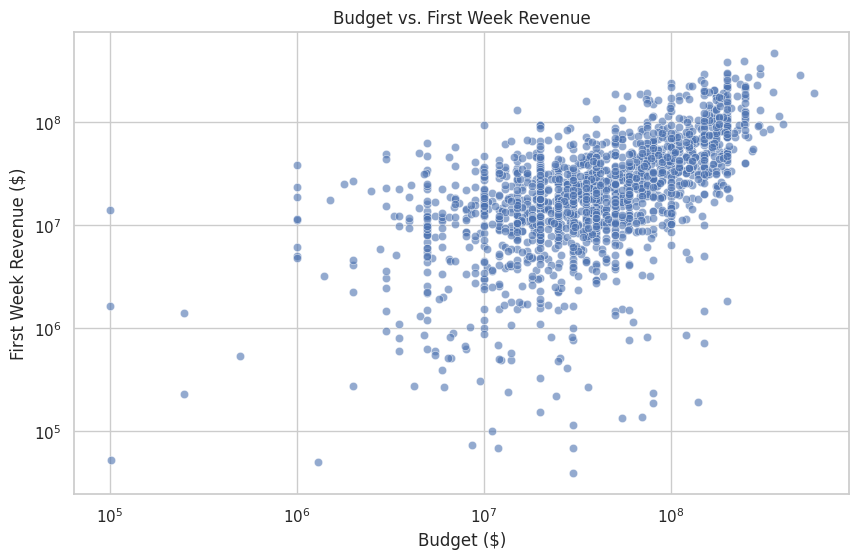

In [28]:
plt.figure(figsize=(10, 6))

# Create scatter plot with transparency (alpha) to handle overlapping points
sns.scatterplot(x='budget', y='first_week_revenue', data=df_features, alpha=0.6)

plt.title('Budget vs. First Week Revenue')
plt.xlabel('Budget ($)')
plt.ylabel('First Week Revenue ($)')

# Set axes to logarithmic scale
# We use a logarithmic scale because the values span huge ranges (from millions to hundreds of millions), making standard linear plots hard to read.
plt.xscale('log')
plt.yscale('log')

plt.show()

There is a clear positive trend—higher budgets generally correlate with higher opening revenues. However, there is significant variance, showing that a high budget doesn't guarantee a hit, and low-budget films can sometimes break out.

## Theatres vs `first_week_revenue`

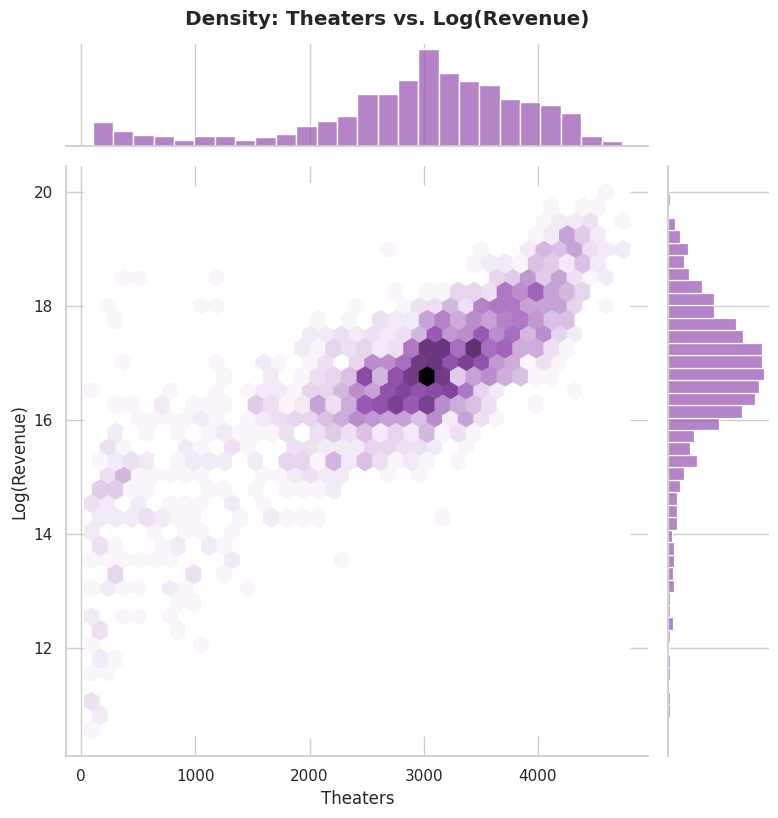

In [29]:
# Apply a logarithmic transformation to 'first_week_revenue' to handle skewness
df_features['log_revenue'] = np.log1p(df_features['first_week_revenue'])

g = sns.jointplot(x='Theaters', y='log_revenue', data=df_features, kind="hex", color="#9b59b6", height=8)
g.fig.suptitle('Density: Theaters vs. Log(Revenue)', weight='bold', y=1.02)
g.set_axis_labels('Theaters', 'Log(Revenue)')
plt.show()

We see a linear relationship indicating that big theatrical releases often bring the best revenues

## Distribution of `first_week_revenue` (Target Variable)

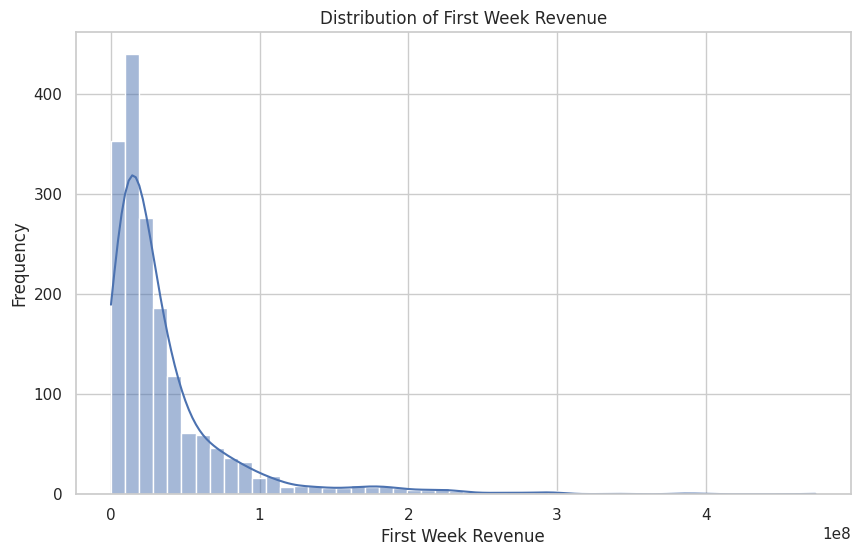

Skewness of first_week_revenue: 3.32


In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(df_features['first_week_revenue'], bins=50, kde=True)
plt.title('Distribution of First Week Revenue')
plt.xlabel('First Week Revenue')
plt.ylabel('Frequency')
plt.show()

# Check for skewness
print(f"Skewness of first_week_revenue: {df_features['first_week_revenue'].skew():.2f}")

* Heavy Right-Skewness: The most striking feature is the long tail extending to the right. This indicates that most movies have relatively lower first-week revenues, while a smaller number of films generate extremely high revenues (the 'blockbusters'). This is very common in financial data, especially for movie box office.

* Concentration at Lower Values: The tall bars on the left side of the histogram show that a large number of movies fall into the lower revenue brackets.

* Skewness Value: The printed skewness of 3.30 quantitatively confirms this observation. A positive skewness value (especially one greater than 1) indicates a high degree of right-skewness. This means the tail on the right side of the distribution is longer or fatter than the left side.

**Why is this important?**

* Model Assumptions: Many linear models assume that the residuals (the errors in prediction) are normally distributed. A skewed target variable often leads to skewed residuals, violating this assumption.

* Impact of Outliers: The high-revenue blockbusters, being far from the mean, can act as influential outliers, disproportionately affecting the model's training and potentially leading to poor generalization for average-performing movies.

* Interpretation: Models trained on skewed data might be less accurate at predicting lower revenue movies or might struggle to differentiate between various levels of high revenue.

**Solution**

We will apply apply a logarithmic transformation (e.g., np.log1p()) to address this during feature engineering.

Why this helps:

* It compresses the scale: The difference between 1M and 10M becomes similar to the difference between 10M and 100M.

* It pulls the outliers in, making the distribution look more like a normal "bell curve."

* Log transformation "linearizes" relationships that are fundamentally multiplicative or exponential. This works because of how logarithms interact with exponents and multiplication.

## Distribution of `budget`

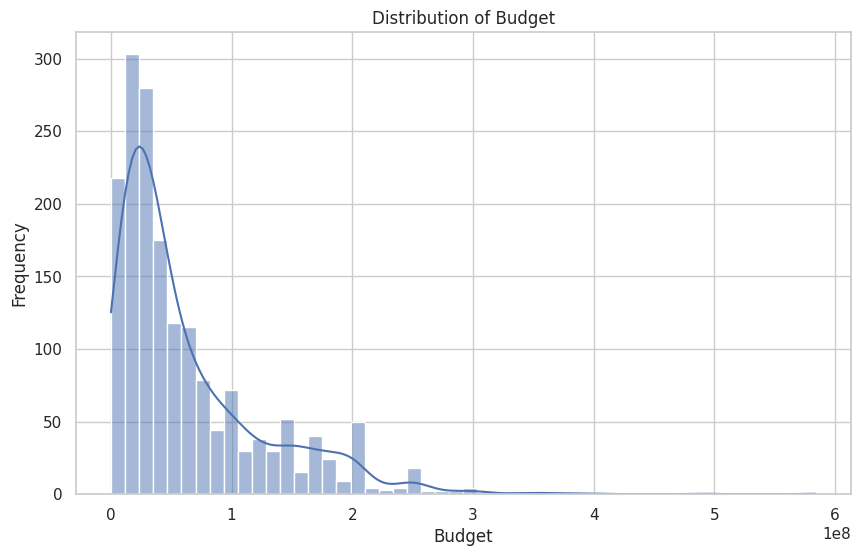

Skewness of budget: 1.92


In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(df_features['budget'], bins=50, kde=True)
plt.title('Distribution of Budget')
plt.xlabel('Budget')
plt.ylabel('Frequency')
plt.show()

# Check for skewness
print(f"Skewness of budget: {df_features['budget'].skew():.2f}")

Budget is also highly right-skewed, just like Revenue. Majority of movies are clustered in the low-budget range (the tall bars on the left) and a few massive blockbusters (like Avatar or Avengers) stretch the X-axis out to $500M+, creating that long slope. We must do log transformation here as well. Some important reasons include:

* Increasing a budget from USD 1M to USD 10M is a game-changer (better camera, real actors).
* Increasing a budget from USD 200M to USD 210M is barely noticeable (maybe 5 extra minutes of CGI).
* Linear models treat every USD 1 as equal. Log transformation fixes this by capturing the relative (percentage) difference rather than the absolute dollar difference.

## Average First Week Revenue by MPAA Rating

Here we see average opening week performance across different MPAA ratings

/tmp/ipython-input-2858048891.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_revenue_mpaa.index, y=avg_revenue_mpaa.values, palette='viridis')


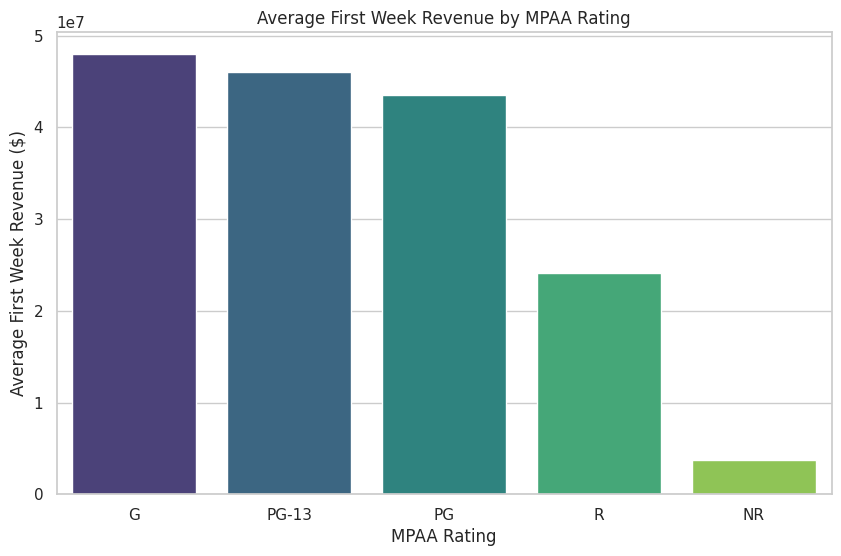

In [32]:
plt.figure(figsize=(10, 6))

# Group by MPAA rating and calculate mean revenue
avg_revenue_mpaa = df_features.groupby('mpaa_rating')['first_week_revenue'].mean().sort_values(ascending=False)

# Create bar plot
sns.barplot(x=avg_revenue_mpaa.index, y=avg_revenue_mpaa.values, palette='viridis')

plt.title('Average First Week Revenue by MPAA Rating')
plt.xlabel('MPAA Rating')
plt.ylabel('Average First Week Revenue ($)')

plt.show()

The chart highlights which target demographics tend to generate the most immediate box office return. Typically, PG-13 and PG movies perform well due to their broader audience appeal compared to R rated films. This can act as a strong feature in our model.

In [33]:
g_rated_films = df_features[df_features['mpaa_rating'] == 'G']
top_5_g_rated_films = g_rated_films.sort_values(by='first_week_revenue', ascending=False).head(3)
display(top_5_g_rated_films)

,imdb_id,budget,mpaa_rating,collection_name,collection_id,keywords,production_companies,main_production_company,director,director_id,...,cast_popularity_sum,primaryTitle,first_week_revenue,Distributor,runtimeMinutes,genres,Theaters,release_date,startYear,log_revenue
1023,tt1979376,175000000,G,Toy Story Collection,10194.0,"friendship, cartoon, rescue mission, sequel, a...",Pixar,Pixar,Josh Cooley,84496.0,...,20.8995,Toy Story 4,178989809,Walt Disney Studios Motion Pictures,100.0,"Adventure,Animation,Comedy",4575.0,2019-06-21,2019,19.002839
37,tt0435761,200000000,G,Toy Story Collection,10194.0,"escape, hostage, college, villain, sequel",Pixar,Pixar,Lee Unkrich,8.0,...,21.5477,Toy Story 3,167551682,Walt Disney Studios Motion Pictures,103.0,"Adventure,Animation,Comedy",4028.0,2010-06-18,2010,18.936802
459,tt1453405,200000000,G,"Monsters, Inc. Collection",137696.0,"friendship, monster, door, training camp, dorm...",Pixar,Pixar,Dan Scanlon,225976.0,...,8.8493,Monsters University,124825448,Walt Disney Studios Motion Pictures,104.0,"Adventure,Animation,Comedy",4004.0,2013-06-21,2013,18.642427


The MPAA ratings explain why kids movies like Toy Story and Monsters, Inc. are massive box office hits.

## Popular Genres

We take a look at if some genres show up more often tan others to decide if genre can be a strong deature for our model.

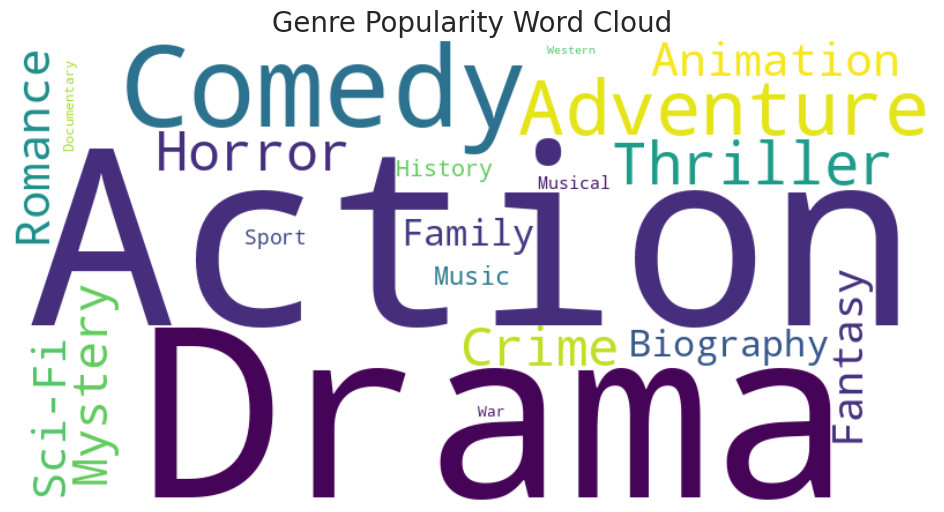

In [34]:
# The 'genres' column has comma-separated strings (e.g., "Action,Adventure").
# We split them and 'explode' them so we can count each individual genre.
all_genres = df_features['genres'].str.split(',').explode().str.strip()
genre_counts = all_genres.value_counts()

# This creates the "cloud" graphic where bigger words = more frequent
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      colormap='viridis').generate_from_frequencies(genre_counts)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') # Remove the x/y axis numbers for a clean look
plt.title('Genre Popularity Word Cloud', fontsize=20)
plt.show()

We have a list of the top genres here and it appears that some genres appear a lot more than others. This can me due to consumer demand and has the potential to act as a strong feature for our model.

But we need to look deeper to realize if more frequent means better revenue or if some genres are stronger revenue drivers than others.

/tmp/ipython-input-74651090.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_revenue_genre.values, y=avg_revenue_genre.index, palette='magma')


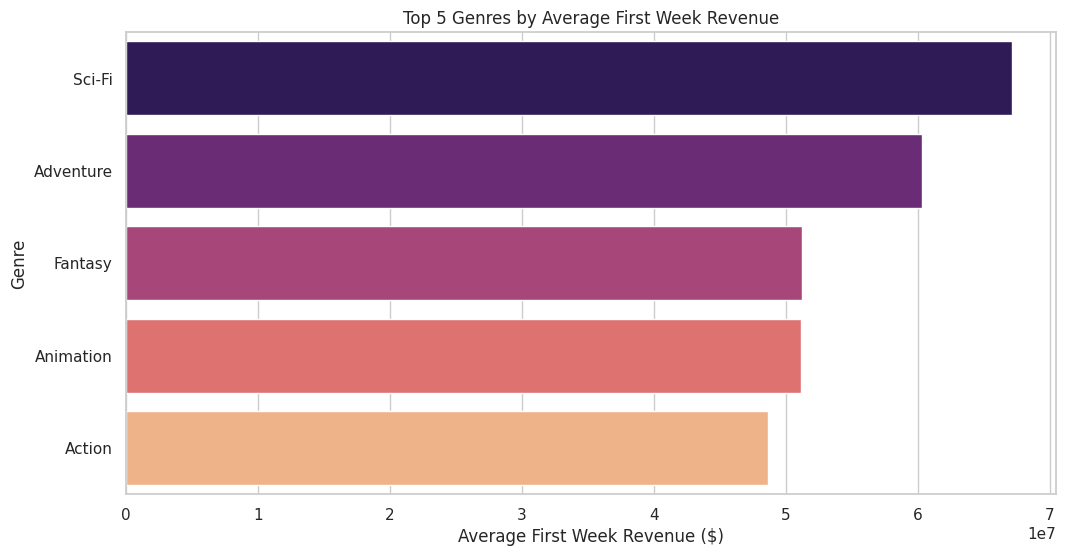

In [35]:
# Create a temporary DataFrame to hold the exploded genres and their corresponding first_week_revenue
df_genre_revenue = pd.DataFrame({
    'genre': all_genres,
    'first_week_revenue': df_features['first_week_revenue'].loc[all_genres.index] # Use .loc for index alignment
})

# Calculate average revenue per genre and take the top 5
avg_revenue_genre = df_genre_revenue.groupby('genre')['first_week_revenue'].mean().sort_values(ascending=False).head(5)

plt.figure(figsize=(12, 6))
sns.barplot(x=avg_revenue_genre.values, y=avg_revenue_genre.index, palette='magma')

plt.title('Top 5 Genres by Average First Week Revenue')
plt.xlabel('Average First Week Revenue ($)')
plt.ylabel('Genre')

plt.show()

Though the number of Sci-Fi films were outnumbered by Actions films and such, the average revenue for Sci-Fi films seems to dominate. A potential reason is that a lot of Sci-Fi films include the other popular genres as well as secondary genres. This indicates that the genres feature can be a strong predictor for the Sci-Fi film (The 3rd Avatar film) we are trying to predict.

## Popular Keywords

Here we take a look at what keywords come up the most in movies

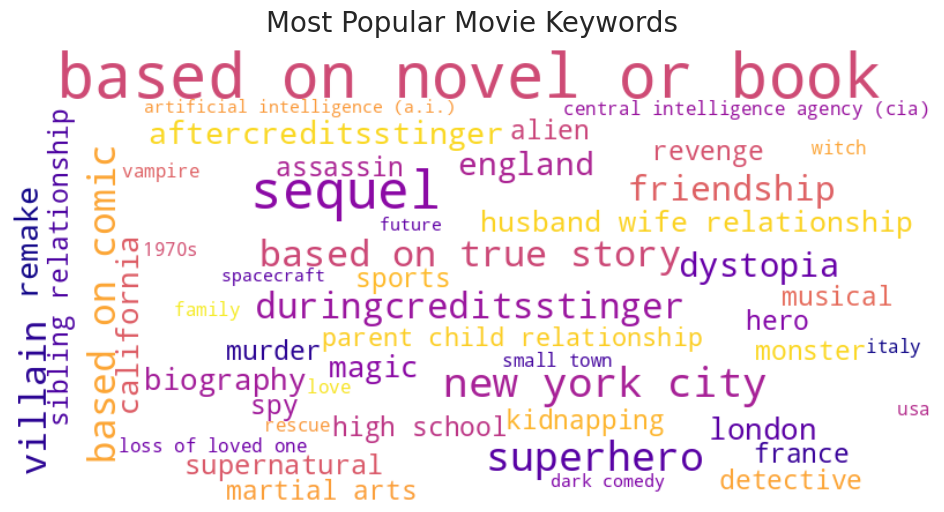

In [36]:
all_keywords = df_features['keywords'].dropna().str.split(',').explode().str.strip()

# Count Frequencies
keyword_counts = all_keywords.value_counts()

# 4. Generate Word Cloud
# We limit to 'max_words=100' to keep it readable
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      colormap='plasma',
                      max_words=50).generate_from_frequencies(keyword_counts)

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Popular Movie Keywords', fontsize=20)
plt.show()

Most films are based on novels or books, while a lot of films are related to New York City. We also see that movies based on comics are popular as well. We will try to look into this further during feature engineering to see if certain kinds of movies affect revenue.

## The Blockbuster Season

This chart reveals the best time of year to release a movie.

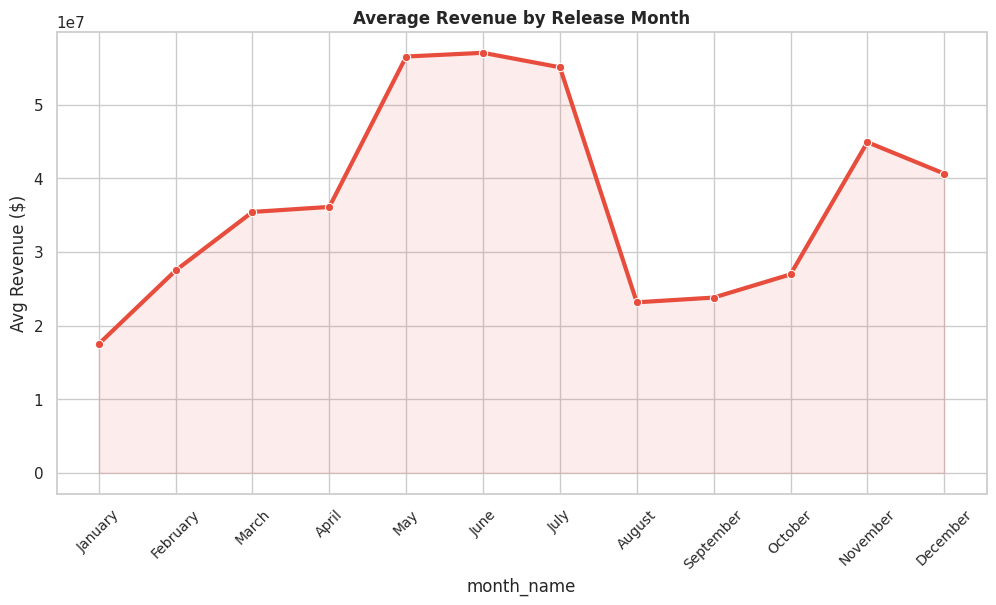

In [37]:
# Seasonality lineplot
df_features['month_name'] = df_features['release_date'].dt.month_name()
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
seasonal_revenue = df_features.groupby('month_name')['first_week_revenue'].mean().reindex(month_order) # We order the movies by month here

plt.figure(figsize=(12, 6))
sns.lineplot(x=seasonal_revenue.index, y=seasonal_revenue.values, marker='o', linewidth=3, color='#e74c3c')
plt.fill_between(seasonal_revenue.index, seasonal_revenue.values, color='#e74c3c', alpha=0.1)
plt.title('Average Revenue by Release Month', weight='bold')
plt.xticks(rotation=45, fontsize=10)
plt.ylabel('Avg Revenue ($)')
plt.show()

May/June/July (Summer Blockbuster season) and November/December (Holiday season). January and September are historically "dump months" with lower average revenues.

This indicates that features relating to holiday season and features that show number of competing films released in the same time frame can act as potentially strong inputs for our model.

## The Evolution of The Industry

Here we see how the budget and revenues for films has changed over the years

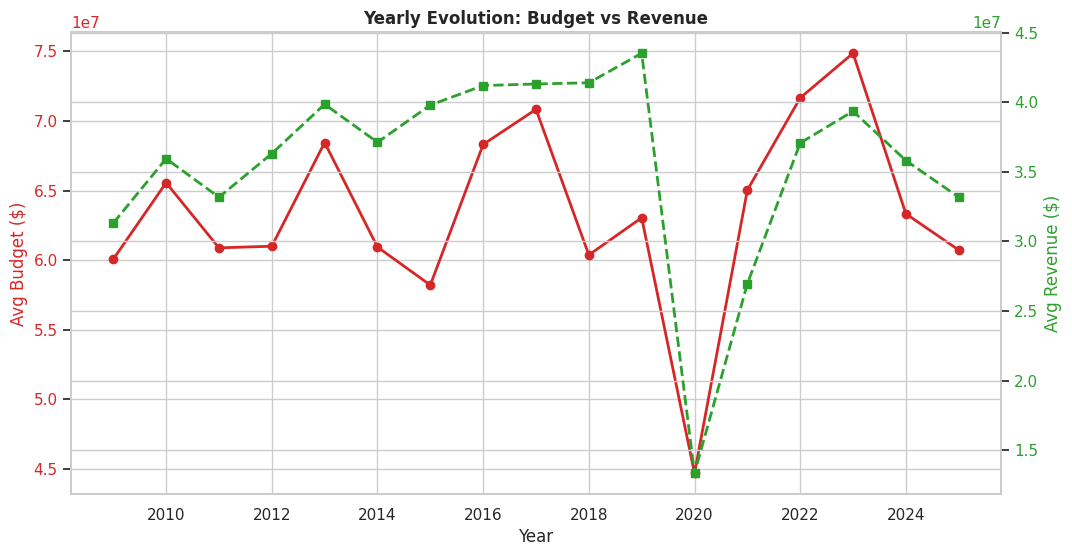

In [38]:
df_features['year'] = df_features['release_date'].dt.year
# Filter for meaningful years
yearly_stats = df_features[df_features['year'] > 2008].groupby('year')[['budget', 'first_week_revenue']].mean()

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Avg Budget ($)', color=color)
ax1.plot(yearly_stats.index, yearly_stats['budget'], color=color, marker='o', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Avg Revenue ($)', color=color)
ax2.plot(yearly_stats.index, yearly_stats['first_week_revenue'], color=color, marker='s', linestyle='--', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Yearly Evolution: Budget vs Revenue', weight='bold')
plt.show()

* Movie revenues saw a general upward trend until covid hit in 2019, while budgets often fluctuated.

**COVID Dip**

* Revenue (Green) likely crashes due to theater closures.
* Budgets also non-existent as there were no movies being released.
* **We need to factor in the anomalies caused by covid in our model.**
* Movie budgets saw big spike post covid but revenue has not reached pre covid levels even today.

## Top Production Companies and Distributors

This ranks the heavy hitters. We get to see if being produced in certain studies can equate to stronger revenues


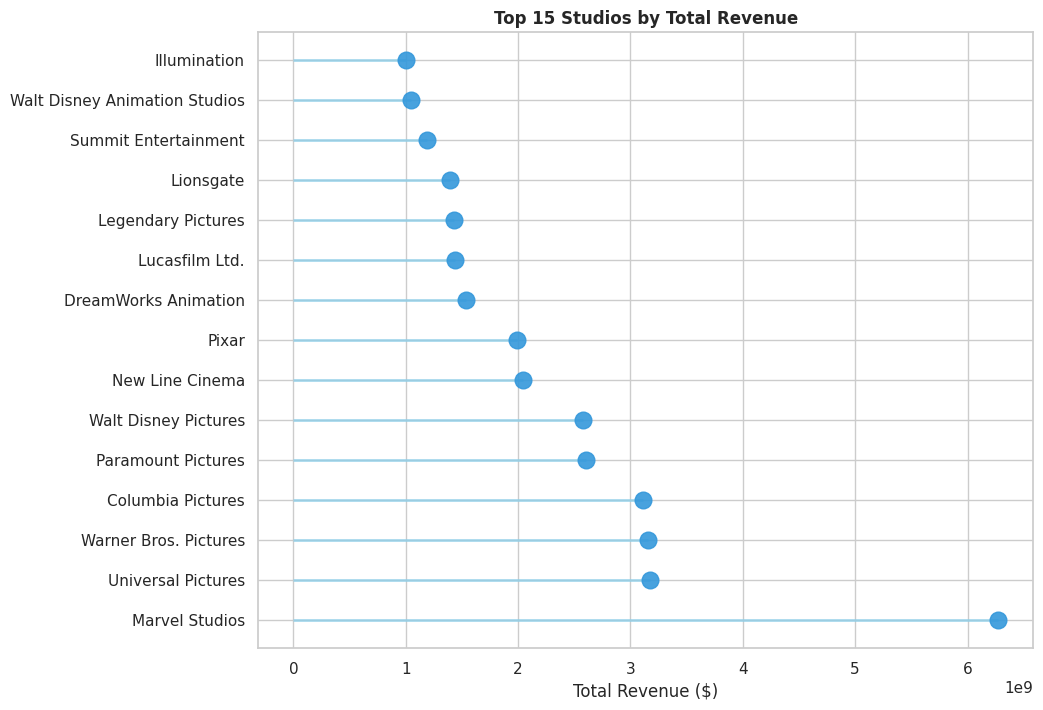

In [39]:
# Aggregate revenue by company
top_companies = df_features.groupby('main_production_company')['first_week_revenue'].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 8))
plt.hlines(y=top_companies.index, xmin=0, xmax=top_companies.values, color='skyblue', alpha=0.7, linewidth=2)
plt.plot(top_companies.values, top_companies.index, "o", markersize=12, color='#3498db', alpha=0.9)
plt.title('Top 15 Studios by Total Revenue', weight='bold')
plt.xlabel('Total Revenue ($)')
plt.show()

This confirms who dominates the market share. We should ideally create a feature that captures the strength of these major comapanies.

## Budget, Revenue, MPAA, Theatres

We take a holistic look at how different features we discussed interact

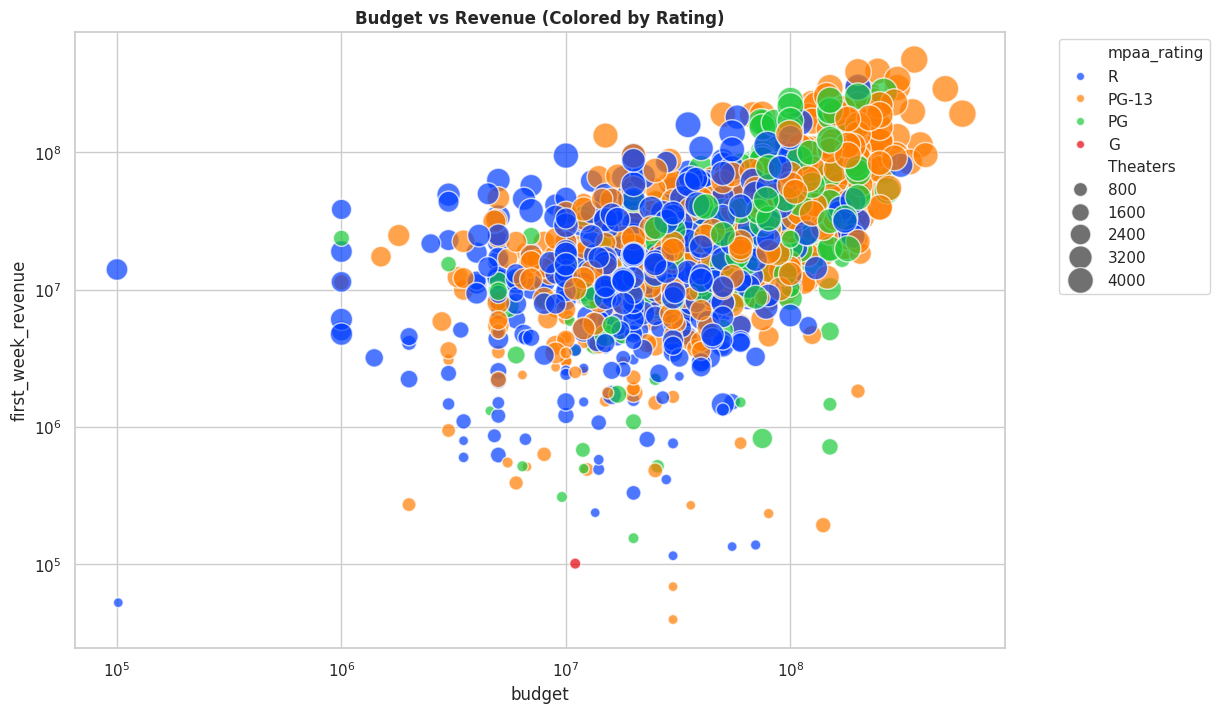

In [40]:
# SCATTER: BUDGET, REVENUE, MPAA, THEATERS
# Filter to main ratings for cleaner plot
main_ratings = ['G', 'PG', 'PG-13', 'R']
df_ratings = df_features[df_features['mpaa_rating'].isin(main_ratings)]

plt.figure(figsize=(12, 8))
sns.scatterplot(x='budget', y='first_week_revenue', hue='mpaa_rating',
                size='Theaters', sizes=(50, 400), alpha=0.7,
                data=df_ratings, palette='bright')
plt.xscale('log')
plt.yscale('log')
plt.title('Budget vs Revenue (Colored by Rating)', weight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

* PG-13 movies often have the biggest budgets
* As production budget increases, first-week revenue consistently increases. (As we already saw)
* The "Glass Ceiling" for R-Rated Movies: They are clustered heavily in the low-to-medium budget range. Studios are probably hesitant to give massive budgets to restrictive movies because the audience pool is smaller.
* You almost never see a tiny dot (limited release) in the high-revenue zone. To get a massive opening week, you must have a wide release (3,000+ theaters).


In [41]:
# Identify the movies with the lowest budgets
lowest_budget_films = df_features.sort_values(by='budget', ascending=True).head(5)
display(lowest_budget_films[['primaryTitle', 'budget', 'first_week_revenue', 'Theaters']])

,primaryTitle,budget,first_week_revenue,Theaters
1879,Winnie-the-Pooh: Blood and Honey,100000,1651754,1652.0
1014,The Gallows,100000,14001591,2720.0
1684,Made in Italy,101339,52332,111.0
1902,Peter Pan's Neverland Nightmare,250000,229949,797.0
1688,Terrifier 2,250000,1413000,886.0


We see an outlier at the low budget end (Low budget, but high revenue). It refers to The Gallows, a film with really bad reviews but great Box Office Performance. This goes to show that Box Office performance is not always linear. Even a poorly rated movie can be profitable.

## Release Day of The Week

Here we see if the day of release affects box office performance

In [42]:
# Transformation
df_features['day_of_week'] = df_features['release_date'].dt.day_name()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Calculate counts
day_counts = df_features['day_of_week'].value_counts().reindex(days_order)

# Calculate counts
day_counts = df_features['day_of_week'].value_counts().reindex(days_order)

# Print counts
print("Movie Counts by Day of Week:")
print(day_counts)

Movie Counts by Day of Week:
day_of_week
Monday         10
Tuesday        16
Wednesday     144
Thursday       63
Friday       1498
Saturday        6
Sunday          2
Name: count, dtype: int64


* Friday (1,498 movies): This confirms that Friday is the standard release day for the vast majority (87%) of films in our dataset. Most movies are released on Fridays because it's the start of the weekend, which maximizes potential audience numbers and opening weekend box office revenue. This tradition originated in Hollywood when Friday was a common pay day, and it persists today as a strategy to capitalize on the public's leisure time during the weekend

* Wednesday (144 movies): This is the secondary slot, typically reserved for major holiday weekends (like Thanksgiving or 4th of July) to get a "head start" on the weekend box office.

* Other Days: Releases on Mondays, Tuesdays, or weekends are extremely rare and usually indicate limited releases, special events, or data anomalies.

/tmp/ipython-input-2815171671.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=avg_revenue.index, y=avg_revenue.values, palette='Blues_d', order=days_order)


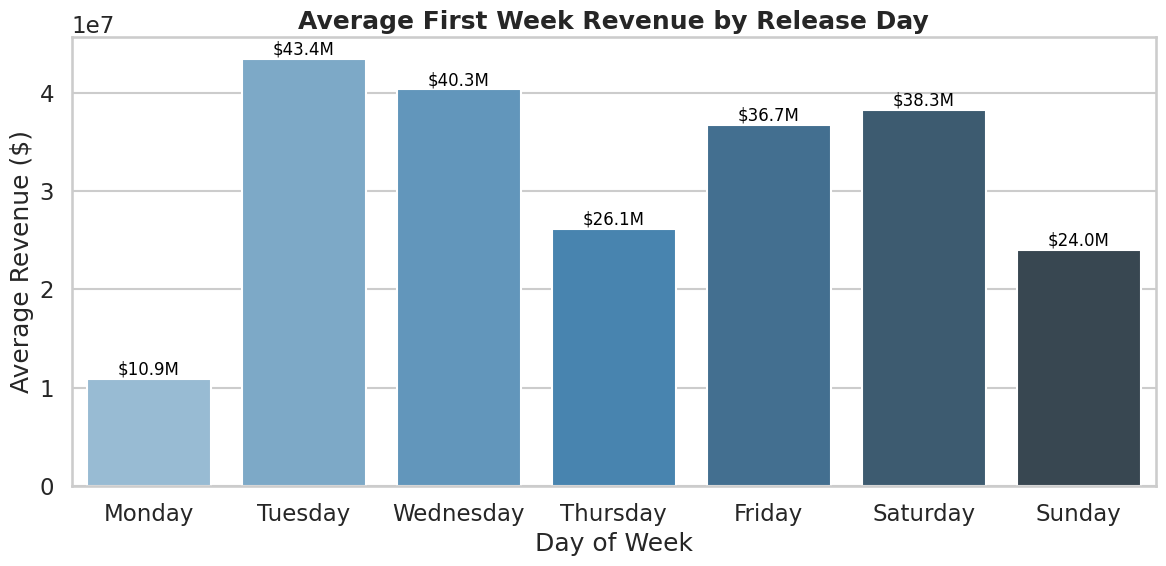

In [43]:
# Calculate Mean (Average) Revenue
avg_revenue = df_features.groupby('day_of_week')['first_week_revenue'].mean().reindex(days_order)

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid", context="talk")

# Create Bar Chart
# 'Blues_d' is a nice professional blue palette
ax = sns.barplot(x=avg_revenue.index, y=avg_revenue.values, palette='Blues_d', order=days_order)

plt.title('Average First Week Revenue by Release Day', weight='bold')
plt.ylabel('Average Revenue ($)')
plt.xlabel('Day of Week')

# Add currency labels on top of each bar
for i, v in enumerate(avg_revenue.values):
    if not np.isnan(v):
        label = f"${v/1000000:.1f}M" # Convert to Millions
        ax.text(i, v, label, ha='center', va='bottom', fontsize=12, color='black')

plt.tight_layout()
plt.show()

Interestingly, movies released on Wednesday often have a higher average opening week than Friday releases. This is usually because Wednesday is reserved for massive blockbusters releasing ahead of a holiday weekend (like Thanksgiving or July 4th), which skews the average upwards. While Friday has the most releases (as seen in the previous count chart), the average is slightly lower because it includes every type of movie, from massive hits to smaller budget films, which dilutes the average.

In [44]:
# We drop the extra columns we created for visualization
columns_to_drop_after_eda = ['log_revenue']
df_features = df_features.drop(columns=columns_to_drop_after_eda, errors='ignore')

print(f"Successfully dropped {columns_to_drop_after_eda} from df_features.")
display(df_features.head(3))

Successfully dropped ['log_revenue'] from df_features.


,imdb_id,budget,mpaa_rating,collection_name,collection_id,keywords,production_companies,main_production_company,director,director_id,...,first_week_revenue,Distributor,runtimeMinutes,genres,Theaters,release_date,startYear,month_name,year,day_of_week
1,tt0458481,65000000,R,Sin City Collection,135179.0,"detective, dystopia, dominatrix, murder, twins","Residaco, Miramax, Troublemaker Studios, Aldam...",Residaco,Frank Miller,2293.0,...,8591561,Dimension Films,102.0,"Action,Crime,Thriller",2894.0,2014-08-22,2014,August,2014,Friday
2,tt0438488,200000000,PG-13,The Terminator Collection,528.0,"army, artificial intelligence (a.i.), saving t...","The Halcyon Company, Moritz Borman Productions...",The Halcyon Company,McG,36425.0,...,71859503,Warner Bros.,115.0,"Action,Adventure,Sci-Fi",3480.0,2009-05-21,2009,May,2009,Thursday
3,tt0417741,250000000,PG,Harry Potter Collection,1241.0,"witch, dying and death, london, england, magic...","Warner Bros. Pictures, Heyday Films",Warner Bros. Pictures,David Yates,11343.0,...,177457914,Warner Bros.,153.0,"Action,Adventure,Family",4275.0,2009-07-15,2009,July,2009,Wednesday


# Feature Engineering

Now that we have a comprehensive understanding of our dataset. We will begin feature engineering.

## Holidays

Though holidays affect movie performance, one big consideration is the number of holidays to include in our model. Adding too many holidays may lead to dimensionality problems when we encode the data. Instead, we should try to find the major holidays that affect movie performance and incorporate those in the model.

We will incorporate a holiday feature which will say **if there was a major holiday during the first 7 days of release of a film**. This will capture the affects of the holiday on box office performance.

In [45]:
# Ensure release_date is datetime
df_features['release_date'] = pd.to_datetime(df_features['release_date'])

# -----------------------------------------------------------------------------
# Dynamic Holiday Date Calculators
# -----------------------------------------------------------------------------

def get_thanksgiving(year):
    """4th Thursday of November"""
    nov_first = pd.to_datetime(f"{year}-11-01")
    return nov_first + relativedelta(weekday=TH(4))

def get_memorial_day(year):
    """Last Monday of May"""
    may_last = pd.to_datetime(f"{year}-05-31")
    return may_last + relativedelta(weekday=MO(-1))

def get_mlk_day(year):
    """3rd Monday of January"""
    jan_first = pd.to_datetime(f"{year}-01-01")
    return jan_first + relativedelta(weekday=MO(3))

def get_presidents_day(year):
    """3rd Monday of February"""
    feb_first = pd.to_datetime(f"{year}-02-01")
    return feb_first + relativedelta(weekday=MO(3))

def get_labor_day(year):
    """1st Monday of September"""
    sep_first = pd.to_datetime(f"{year}-09-01")
    return sep_first + relativedelta(weekday=MO(1))

def get_all_holidays_for_year(year):
    """Returns a dictionary of all major holidays for a given year."""
    return {
        # Floating Holidays
        'Thanksgiving': get_thanksgiving(year),
        'Memorial_Day': get_memorial_day(year),
        'MLK_Day': get_mlk_day(year),
        'Presidents_Day': get_presidents_day(year),
        'Labor_Day': get_labor_day(year),

        # Fixed Holidays
        'Christmas': pd.to_datetime(f"{year}-12-25"),
        'Christmas_Eve': pd.to_datetime(f"{year}-12-24"),
        'New_Years_Day': pd.to_datetime(f"{year}-01-01"),
        'New_Years_Eve': pd.to_datetime(f"{year}-12-31"),
        'July_4th': pd.to_datetime(f"{year}-07-04"),
        'Valentines_Day': pd.to_datetime(f"{year}-02-14"),
        'Halloween': pd.to_datetime(f"{year}-10-31"),
    }

Considering the release a holiday release only if the movie started airing on holidays limits the amount of information. As we are predicting revenue of first 7 days, we will consider the movie as a holiday release if a holiday falls within the 7 days.

In [46]:
# -----------------------------------------------------------------------------
# Find Nearest Holiday Within Window (We check if there is a holiday in the 7 days when a movie screens)
# -----------------------------------------------------------------------------

def find_nearest_holiday(release_date, window_days=7):
    """Finds the nearest major holiday within the specified window."""
    if pd.isna(release_date):
        return 'None'

    year = release_date.year

    # Get holidays for current year and adjacent years (for Dec/Jan edge cases)
    all_holidays = {}
    for y in [year - 1, year, year + 1]:
        try:
            holidays = get_all_holidays_for_year(y)
            all_holidays.update({f"{name}_{y}": date for name, date in holidays.items()})
        except:
            continue

    nearest_holiday = None
    min_diff = float('inf')

    for name, holiday_date in all_holidays.items():
        diff = abs((release_date - holiday_date).days)

        if diff <= window_days and diff < min_diff:
            min_diff = diff
            nearest_holiday = name.rsplit('_', 1)[0]  # Remove year suffix

    return nearest_holiday if nearest_holiday else 'None'

In [47]:
# -----------------------------------------------------------------------------
# Apply to DataFrame
# -----------------------------------------------------------------------------

print("Calculating nearest holiday for each movie...")
df_features['nearest_holiday'] = df_features['release_date'].apply(
    lambda x: find_nearest_holiday(x, window_days=7)
)

print("\n--- Holiday Distribution ---")
print(df_features['nearest_holiday'].value_counts())

Calculating nearest holiday for each movie...

--- Holiday Distribution ---
nearest_holiday
None              1095
Valentines_Day      71
Thanksgiving        71
MLK_Day             70
July_4th            70
Halloween           67
Memorial_Day        66
Christmas_Eve       56
Labor_Day           50
Presidents_Day      43
New_Years_Day       40
Christmas           40
Name: count, dtype: int64


In [48]:
# -----------------------------------------------------------------------------
# Analyze Revenue by Individual Holiday
# -----------------------------------------------------------------------------

holiday_means = df_features.groupby('nearest_holiday')['first_week_revenue'].mean().sort_values(ascending=False)

for holiday, avg in holiday_means.items():
    print(f"  {holiday:20s}: ${avg:,.0f}")

print(f"\n  {'Global Average':20s}: ${df_features['first_week_revenue'].mean():,.0f}")

  July_4th            : $63,676,812
  Thanksgiving        : $55,672,956
  Memorial_Day        : $54,724,394
  Christmas_Eve       : $50,250,103
  None                : $35,428,357
  Valentines_Day      : $35,203,631
  Halloween           : $29,711,238
  Christmas           : $28,133,885
  Labor_Day           : $27,689,559
  Presidents_Day      : $22,512,777
  MLK_Day             : $20,097,729
  New_Years_Day       : $13,111,408

  Global Average      : $36,532,096


While many holiday films bring better revenues on average, there seems to be a discrepancy during Christmas. The number of movies released during Christmas suggest that it is a popular season for movie releases. The reason for the low average might be due to the fact that a lot of films (even poor ones) try to target this period.

We see clear differences in movie performance due to holidays. We will now attempt to create features from this and grouping the holidays based on their impact.

In [49]:
# -----------------------------------------------------------------------------
# Create Holiday Groups
# -----------------------------------------------------------------------------

def categorize_holiday(holiday_name):
    """Groups holidays into meaningful categories."""
    if holiday_name in ['Memorial_Day', 'July_4th']:
        return 'Summer_Major'
    elif holiday_name == 'Thanksgiving':
        return 'Thanksgiving'
    elif holiday_name in ['Christmas', 'Christmas_Eve', 'New_Years_Day', 'New_Years_Eve']:
        return 'Winter'
    elif holiday_name in ['MLK_Day', 'Presidents_Day', 'Labor_Day', 'Valentines_Day', 'Halloween']:
        return 'Minor_Holiday'
    else:
        return 'None'

df_features['holiday_group'] = df_features['nearest_holiday'].apply(categorize_holiday)

print("\n--- Holiday Group Distribution ---")
print(df_features['holiday_group'].value_counts())


--- Holiday Group Distribution ---
holiday_group
None             1095
Minor_Holiday     301
Summer_Major      136
Winter            136
Thanksgiving       71
Name: count, dtype: int64


Finally we further group them by if they are Major holidays or not.

We will also try to incorporate the more granular holiday grouping into our model to see if it improves our model.

In [50]:
# -----------------------------------------------------------------------------
# Create Final Holiday Features
# -----------------------------------------------------------------------------

# One-Hot Encode Holiday Groups
holiday_dummies = pd.get_dummies(
    df_features['holiday_group'],
    prefix='holiday',
    drop_first=True,
    dtype=int
)
df_features = pd.concat([df_features, holiday_dummies], axis=1)

major_holidays = ['Summer_Major', 'Thanksgiving', 'Winter']
df_features['is_major_holiday'] = df_features['holiday_group'].apply(
    lambda x: 1 if x in major_holidays else 0
)

In [51]:
avatar_films = df_features[df_features['primaryTitle'].str.contains('Avatar', case=False, na=False)]
display(avatar_films[['primaryTitle', 'year', 'is_major_holiday']])

,primaryTitle,year,is_major_holiday
160,Avatar,2009,1
544,Avatar: The Way of Water,2022,0


In [52]:
df_features.columns

Index(['imdb_id', 'budget', 'mpaa_rating', 'collection_name', 'collection_id',
       'keywords', 'production_companies', 'main_production_company',
       'director', 'director_id', 'director_popularity', 'top_cast',
       'main_actor_name', 'main_actor_id', 'main_actor_popularity',
       'cast_popularity_sum', 'primaryTitle', 'first_week_revenue',
       'Distributor', 'runtimeMinutes', 'genres', 'Theaters', 'release_date',
       'startYear', 'month_name', 'year', 'day_of_week', 'nearest_holiday',
       'holiday_group', 'holiday_None', 'holiday_Summer_Major',
       'holiday_Thanksgiving', 'holiday_Winter', 'is_major_holiday'],
      dtype='object')

In [53]:
# Dropping extra columns
df_features.drop(columns=['nearest_holiday',
       'holiday_group', 'holiday_None', 'holiday_Summer_Major',
       'holiday_Thanksgiving', 'holiday_Winter'], inplace=True, errors='ignore')

In [54]:
df_features.columns

Index(['imdb_id', 'budget', 'mpaa_rating', 'collection_name', 'collection_id',
       'keywords', 'production_companies', 'main_production_company',
       'director', 'director_id', 'director_popularity', 'top_cast',
       'main_actor_name', 'main_actor_id', 'main_actor_popularity',
       'cast_popularity_sum', 'primaryTitle', 'first_week_revenue',
       'Distributor', 'runtimeMinutes', 'genres', 'Theaters', 'release_date',
       'startYear', 'month_name', 'year', 'day_of_week', 'is_major_holiday'],
      dtype='object')

## Seasonality

Some months are more poised towards blockbuster releases than others (We saw the differences during EDA). We try to capture that here.

                    mean  count      median
month_name                                 
January     1.750330e+07    147  14710266.0
February    2.749016e+07    153  18241349.0
March       3.544070e+07    150  22796313.0
April       3.612169e+07    129  18913765.0
May         5.655201e+07    128  35694244.5
June        5.705512e+07    136  37387561.5
July        5.508912e+07    147  33901882.0
August      2.316185e+07    174  16036737.5
September   2.380512e+07    144  17618813.0
October     2.695747e+07    141  19434159.0
November    4.491799e+07    148  24746258.0
December    4.064305e+07    142  22044852.5


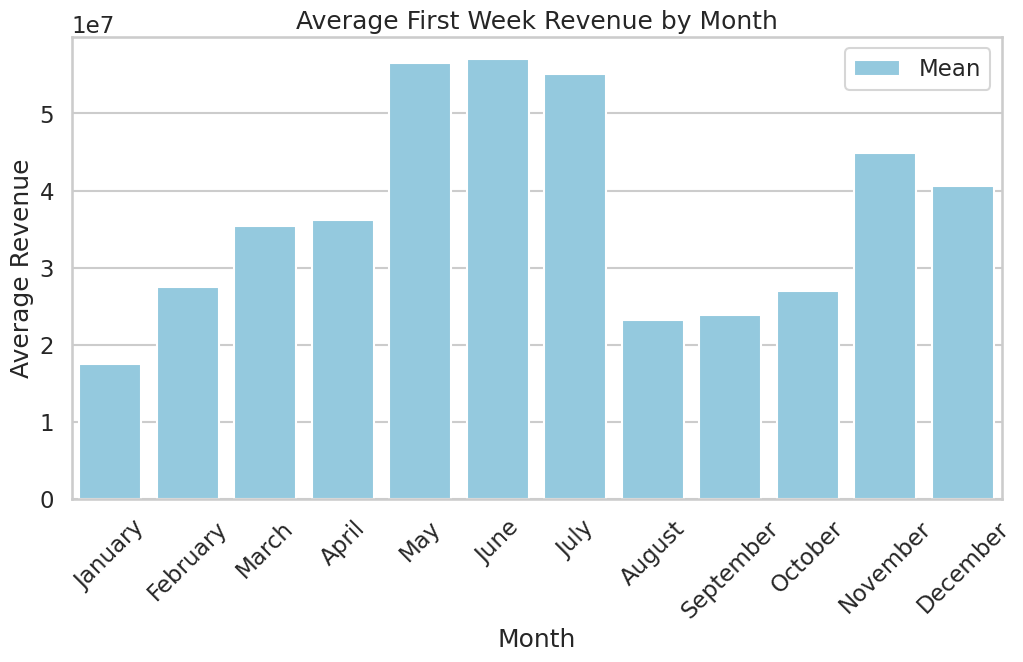

In [55]:
# Group by month and calculate average revenue
# Ensure months are ordered correctly
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']


monthly_stats = df_features.groupby('month_name')['first_week_revenue'].agg(['mean', 'count', 'median']).reindex(month_order)


print(monthly_stats)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_stats.index, y=monthly_stats['mean'], color='skyblue', label='Mean')
plt.title('Average First Week Revenue by Month')
plt.xlabel('Month')
plt.ylabel('Average Revenue')
plt.xticks(rotation=45)
plt.savefig('avg_revenue_by_month.png')

* May, June, July seem to be the blockbuster season
* November, December seem to be the holiday season
* The other months seem to be low performing

We will create features based on the 12 months to capture this pattern

In [56]:
# One-Hot Encoding for 12 Months
# We use prefix='month' so you get columns like 'month_January', 'month_February'
# drop_first=True is generally good practice to reduce redundancy and avoid multicollinearity issues (k-1 categories),
df_features = pd.get_dummies(df_features, columns=['month_name'], prefix='month', drop_first=True, dtype=int)

# Verification
august_rev = df_features[df_features['month_August'] == 1]['first_week_revenue'].mean()
june_rev = df_features[df_features['month_June'] == 1]['first_week_revenue'].mean()

print(f"Average Revenue for June releases:   ${june_rev:,.2f}")
print(f"Average Revenue for August releases: ${august_rev:,.2f}")

Average Revenue for June releases:   $57,055,117.57
Average Revenue for August releases: $23,161,850.14


## Release Year

We want to create a feature to capture release year to ensure the model understands macro factors like:

* Inflation: Ticket prices rise almost every year. The reason we don't adjust our financial metric using something like consumer price index is because ticket prices don't always change the same way as overall inflation. Using an overall metric like CPI may introduce noise in our dataset.

* Market Growth: The number of screens and global reach has expanded.

* Streaming Era: Recent years (post-2020) have different dynamics than pre-2019.

In [57]:
# We drop the previous year column to ensure data accuracy
df_features.drop(columns=['startYear'], inplace=True, errors='ignore')

# 3. Ensure 'year' is formatted correctly
# We keep this NUMERICAL (as an integer). Do NOT encode this.
df_features['release_date'] = pd.to_datetime(df_features['release_date'])
df_features['year'] = df_features['release_date'].dt.year

## Day of The Week

Movie revenue performances vary somewhat based on the day they were released on. We already have a day of the week column which we will encode here for modeling.

In [58]:
df_features['day_of_week'].head()

,day_of_week
1,Friday
2,Thursday
3,Wednesday
4,Thursday
5,Friday


In [59]:
df_features = pd.get_dummies(df_features, columns=['day_of_week'], prefix='day', drop_first=True, dtype=int)

## Competition

We find the number of competing films during a movie's release to see how it affects performance. Box office is a zero-sum game to some extent. If 5 movies open on the same Friday, audiences split up. If a movie opens alone, it has more scope to dominate.

In [60]:
# Define the Feature Logic
def get_competition_count(row, all_data):
    """
    Counts how many OTHER movies were released in the 7-day window
    starting from this movie's release date.

    Logic:
    - Start Date: The movie's release date.
    - End Date: 6 days later (creating a 7-day inclusive window).
    - Condition: Count rows where release_date is inside this window
                 AND the movie is NOT the one we are currently checking.
    """
    start_date = row['release_date']
    end_date = row['release_date'] + timedelta(days=6)

    # Filter for other movies releasing in this window
    mask = (all_data['release_date'] >= start_date) & \
           (all_data['release_date'] <= end_date) & \
           (all_data['imdb_id'] != row['imdb_id']) # Exclude itself

    return all_data[mask].shape[0]

# Apply the Feature
print("Calculating competition...")
df_features['competition_count'] = df_features.apply(lambda row: get_competition_count(row, df_features), axis=1)

# Verify the Results
print("\nCompetition Count Distribution:")
print(df_features['competition_count'].value_counts().sort_index())

Calculating competition...

Competition Count Distribution:
competition_count
0     252
1     573
2     536
3     233
4      83
5      19
6       7
7      10
25     26
Name: count, dtype: int64


The 26 films competing against 25 other films seem to be an anomaly. We will now try to see if this is an issue.

In [61]:
anomalies = df_features[df_features['competition_count'] == 25].copy()


print("\nList of Movies with Issue:")
# Display titles to confirm they are 2008/2009 era movies
display(anomalies[['primaryTitle', 'release_date', 'Distributor', 'budget']].sort_values('primaryTitle'))


List of Movies with Issue:


,primaryTitle,release_date,Distributor,budget
45,Bedtime Stories,2009-01-01,Walt Disney Studios Motion Pictures,80000000
104,Beverly Hills Chihuahua,2009-01-01,Walt Disney Studios Motion Pictures,20000000
63,Body of Lies,2009-01-01,Warner Bros.,70000000
81,Bolt,2009-01-01,Walt Disney Studios Motion Pictures,150000000
11,Changeling,2009-01-01,Universal Pictures,55000000
80,Eagle Eye,2009-01-01,DreamWorks,80000000
67,Four Christmases,2009-01-01,Warner Bros.,80000000
61,Frost/Nixon,2009-01-01,Universal Pictures,25000000
62,High School Musical 3: Senior Year,2009-01-01,Walt Disney Studios Motion Pictures,11000000
51,Madagascar: Escape 2 Africa,2009-01-01,DreamWorks,150000000


Upon checking these movies we find that these movies were all released in late December of 2008. The Box Office Data only starts from 2009 and thus these films likely don't have revenue for full 7 days and hence are faulty. It is ideal to remove them.

In [62]:
# This removes the films that were competing with 25 others due to a data error
df_features = df_features[df_features['competition_count'] != 25].copy()

# Reset index just to be clean
df_features.reset_index(drop=True, inplace=True)

print(f"Remaining rows: {len(df_features)}")
print(f"Max Competition: {df_features['competition_count'].max()}")

Remaining rows: 1713
Max Competition: 7


In [63]:
df_features['competition_count'].value_counts()

,count
competition_count,
1,573
2,536
0,252
3,233
4,83
5,19
7,10
6,7


To check whether competition actually negatively affects performance or not we check correlation.

In [64]:
correlation = df_features['competition_count'].corr(df_features['first_week_revenue'])

print(f"Correlation between Competition and Revenue: {correlation:.4f}")

Correlation between Competition and Revenue: -0.1392


The negative correlation indicates this feature is valuable and we will be keeping it for modeling.

In [65]:
# Sanity Check
avatar_movies = df_features[df_features['primaryTitle'].str.contains('Avatar', case=False, na=False)]
display(avatar_movies[['primaryTitle', 'year', 'competition_count', 'budget', 'first_week_revenue']])

,primaryTitle,year,competition_count,budget,first_week_revenue
107,Avatar,2009,3,237000000,137094051
457,Avatar: The Way of Water,2022,1,350000000,197681686


## Bankability (Actors and Directors)

Now will attempt to measure the influence of popular actors and directors and movies. We will take a look at the TMDB popularity values but they are likely faulty as they only contain current data. So we will need other methods to calculate bankability.

In [66]:
avatar_films = df_features[df_features['primaryTitle'].str.contains('Avatar', case=False, na=False)]
display(avatar_films[['primaryTitle', 'year', 'main_actor_popularity', 'director_popularity','genres']])

,primaryTitle,year,main_actor_popularity,director_popularity,genres
107,Avatar,2009,3.801,4.1496,"Action,Adventure,Fantasy"
457,Avatar: The Way of Water,2022,3.801,4.1496,"Action,Adventure,Fantasy"


The TMDB values have data leakage. The mainn actor and director of the Avatar films did not have the popularity they have now back when the first Avatar film was released. We need a way to measure their bankability.

In our approach we will calculate the average revenue of the previous movies by each actor and director to measure their influence.

A major challenge however is accounting for actors and directors with no historical data. We use imputation to solve that.

**The Logic Implemented**
* Rolling Window: For every director/actor, I looked at their previous movies (excluding the current one to avoid data leakage).

* Metric: I averaged the Revenue of those movies.

* Smart Imputation: For a director's first movie in the dataset (where they have no history), we create 10 "Buckets" of budget size and impute accordingly. It sets a realistic "baseline expectation" for the model rather than assuming every new director is a disaster (0).

In [67]:
# We MUST sort by date first to make use of the "expanding" window
df_features['release_date'] = pd.to_datetime(df_features['release_date'])
df_features = df_features.sort_values('release_date')

#  DEFINE THE CALCULATION LOGIC
def calculate_past_track_record(df_features, group_col, target_col):
    """
    Calculates the average revenue of ALL previous movies for a director/actor.

    Logic:
    - expanding(): Creates a growing window (Movie 1, then Movies 1+2, then 1+2+3...)
    - mean(): Takes the average of that window.
    - shift(1): CRITICAL. Moves the calculated average down one row.
      This ensures Movie 3's score is based on Movies 1 & 2, NOT Movie 3 itself.
    """
    return df_features.groupby(group_col)[target_col].transform(
        lambda x: x.expanding().mean().shift(1)
    )

# Using 'director' and 'main_actor_name' columns from the dataset
# Using first_week_revenue as the target
df_features['director_bankability'] = calculate_past_track_record(df_features, 'director', 'first_week_revenue')
df_features['actor_bankability'] = calculate_past_track_record(df_features, 'main_actor_name', 'first_week_revenue')


# Imputation

# Step A: Create 10 "Buckets" of budget size (Deciles)
# Using 'budget' to match the currency of first_week_revenue
df_features['budget_bucket'] = pd.qcut(df_features['budget'], q=10, labels=False, duplicates='drop')

# Step B: Calculate the median revenue for EACH bucket
# transform('median') gives us a column where every row has the median revenue OF ITS BUCKET
bucket_medians = df_features.groupby('budget_bucket')['first_week_revenue'].transform('median')

# Fill NaNs with these bucket medians
df_features['director_bankability'] = df_features['director_bankability'].fillna(bucket_medians)
df_features['actor_bankability'] = df_features['actor_bankability'].fillna(bucket_medians)

# CLEANUP
# Drop the helper column
df_features.drop(columns=['budget_bucket'], inplace=True)

print("✅ Bankability features created successfully.")
print(df_features[['primaryTitle', 'budget', 'first_week_revenue', 'director_bankability', 'actor_bankability']].head())

✅ Bankability features created successfully.
            primaryTitle    budget  first_week_revenue  director_bankability  \
28            Bride Wars  30000000            25827125            15736584.5   
51            The Unborn  16000000            23239155            11941474.0   
66        Hotel for Dogs  35000000            24594815            19089812.0   
60  Paul Blart: Mall Cop  26000000            43300198            15736584.5   
58   My Bloody Valentine  15000000            27674736            11941474.0   

    actor_bankability  
28         15736584.5  
51         11941474.0  
66         19089812.0  
60         15736584.5  
58         11941474.0  


In [68]:
df_features['director_bankability'] = df_features['director_bankability'].round().astype(int)
df_features['actor_bankability'] = df_features['actor_bankability'].round().astype(int)


In [69]:
# Sanity check
james_films = df_features[df_features['director'] == 'James Cameron']
display(james_films[['primaryTitle', 'year', 'director_bankability']].sort_values(by='year'))

,primaryTitle,year,director_bankability
107,Avatar,2009,91000048
457,Avatar: The Way of Water,2022,137094051


Bakability of James Cameroon also rose after the success of Avatar 1

In [70]:
director_bankability_corr = df_features['director_bankability'].corr(df_features['first_week_revenue'])
actor_bankability_corr = df_features['actor_bankability'].corr(df_features['first_week_revenue'])

print(f"Correlation between Director Bankability and Adjusted Revenue: {director_bankability_corr:.4f}")
print(f"Correlation between Actor Bankability and Adjusted Revenue: {actor_bankability_corr:.4f}")

Correlation between Director Bankability and Adjusted Revenue: 0.5105
Correlation between Actor Bankability and Adjusted Revenue: 0.4270


Our bankability feature is not perfect as we have to rely on imputation for some values, but this is still much better than the leaky popularity scores we got from TMDB.

The correlation scores further suggest that the calculated bankability scores can act as strong indicators. This is especially true for big actors/directors who have many films.

### Director Experience

Directors tend to build their profiles over the course of releasing multiple movies. We create a feature that captures the maturiy of the directors in our dataset.

In [71]:
# Add director experience (count of prior movies)
df_features = df_features.sort_values('release_date')
df_features['director_experience'] = df_features.groupby('director').cumcount()

## Covid

We already saw that the movie industry took a big hit during Covid. We will now make a feature that attempts to capture the anomaly.

In [72]:
# Define the Window
covid_start = pd.to_datetime('2020-03-01') # This is when lockdowns began in the US
covid_end = pd.to_datetime('2021-07-01') # This is when theatres started opening widely

# Create Feature
def check_covid_window(release_date):
    if pd.isna(release_date): return 0
    if covid_start <= release_date <= covid_end:
        return 1
    return 0

df_features['is_covid_period'] = df_features['release_date'].apply(check_covid_window)

# Check the Counts
print("COVID Feature Distribution:")
print(df_features['is_covid_period'].value_counts())

#  See which movies fell into this bucket
display(df_features[df_features['is_covid_period'] == 1][['primaryTitle', 'release_date', 'first_week_revenue', 'is_covid_period']].head(5))

COVID Feature Distribution:
is_covid_period
0    1658
1      55
Name: count, dtype: int64


,primaryTitle,release_date,first_week_revenue,is_covid_period
1380,Baaghi 3,2020-03-06,666661,1
1258,Onward,2020-03-06,49758687,1
1298,The Way Back,2020-03-06,11020873,1
1270,The Hunt,2020-03-13,5812500,1
1369,I Still Believe,2020-03-13,9868521,1


55 films were released during the covid period and we have a feature to address the issues with lockdown now.

## Distributor

The distributor behind a movie plays a big role behind how big a movie's release will be. However, we need to be aware of dimensionality issues when creating this feature as the number of unique distributors is high and making a dummy column for each of them may lead to sparse data and bad predictability. So, we divide them into different classes. We will now explore further to understand how many classes are appropiate.

We will first create features based on the number of movies a distributor has (This measures the breadth of the studio) and then a feature for their bankability (Measures the popularity of the studio and how much financial success they have seen).

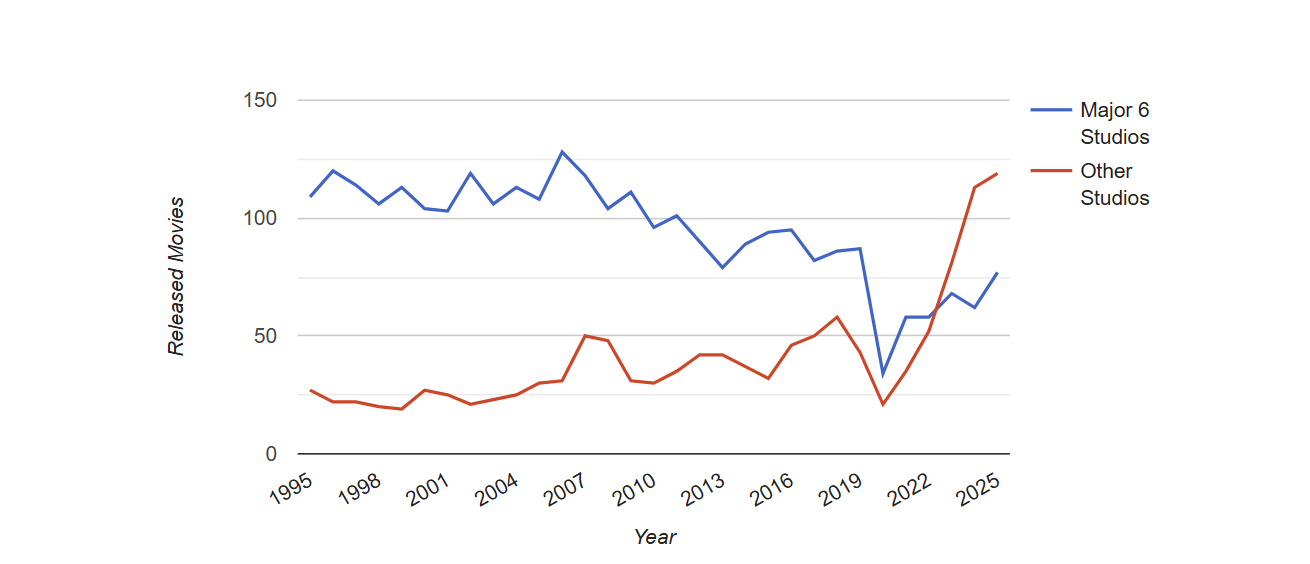

The chart above from The Numbers show the number of films released by studios other than the big 6 have been on the rise since covid. We will try to create distributor tiers which captures the big players, rising studios and other studios.

In [73]:
# Total Number of Unique Distributors
total_unique_distributors = df_features['Distributor'].nunique()
print(f"Total Unique Distributors: {total_unique_distributors}\n")

# List the Top 15 Distributors by Movie Count
print("Top 15 Distributors (by frequency):")
print(df_features['Distributor'].value_counts().head(30))

Total Unique Distributors: 93

Top 15 Distributors (by frequency):
Distributor
Warner Bros.                           248
Universal Pictures                     228
20th Century Studios                   157
Lionsgate                              150
Sony Pictures Releasing                148
Walt Disney Studios Motion Pictures    142
Paramount Pictures                     126
Focus Features                          45
Screen Gems                             44
STX Entertainment                       25
A24                                     25
Relativity Media                        23
Open Road Films (II)                    23
TriStar Pictures                        23
DreamWorks                              16
Summit Entertainment                    15
The Weinstein Company                   14
Roadside Attractions                    14
United Artists Releasing                13
Neon                                    12
FilmDistrict                            10
Columbia Pictures 

There is a clear hierarchy that separates the biggest and smallest studies. We will now attempt to create 3 tiers and see if there are meaningful differences among them.

In [74]:
# Calculate the counts for each distributor dynamically
distributor_counts = df_features['Distributor'].value_counts()

# Define the Categorization Function based on the specific count thresholds
def categorize_distributor(distributor_name):
    # Retrieve the count for this specific distributor
    # Default to 0 if not found (safety check)
    count = distributor_counts.get(distributor_name, 0)

    if count > 120:
        return 'Major'
    elif count > 14:
        return 'Medium'
    else:
        return 'Small'

df_features['distributor_category'] = df_features['Distributor'].apply(categorize_distributor)

# Checking the raw counts of the categories before encoding
print("Category distribution before encoding:")
print(df_features['distributor_category'].value_counts())

Category distribution before encoding:
distributor_category
Major     1199
Small      275
Medium     239
Name: count, dtype: int64


Most of the distributors are major which makes sense as our dataset was already filtered to keep big theatrical releases.

In [75]:
# Aggregate
avg_rev = df_features.groupby('distributor_category')['first_week_revenue'].mean().reindex(['Major', 'Medium', 'Small'])

avg_rev = avg_rev.astype(int)
avg_rev

,first_week_revenue
distributor_category,
Major,45603092
Medium,21738573
Small,12478517


The average revenues for each class of distributor are different enough to be meaningful

The 3 classes have distinct differences.

* Major Studios: Average $45M. (The Blockbuster Factory)

* Medium Studios: Average $21M. (Solid hits, often genre-specific or prestige films)

* Small Studios: Average $12M. (Niche, indie, or limited releases)



**Encoding this feature**

In [76]:
# One-Hot Encode the new feature with drop_first=True
# drop_first=True is used to prevent multicollinearity (dummy variable trap)
# e.g., if it's not Medium and not Small, it implies Major.
df_features = pd.get_dummies(
    df_features,
    columns=['distributor_category'],
    prefix='dist_cat',
    drop_first=True, dtype=int
)

We don't make a similar feature for the production company because the data we have gives us a list of all the main production companies behind a movie. Working with that data might just bring more noise than information.

## Distributor Bankability

The previous features captured the scale of distributors. This one will capture their bankability.

In [77]:
# Sort by Date
df_features['release_date'] = pd.to_datetime(df_features['release_date'])
df_features = df_features.sort_values('release_date')

# DEFINE CALCULATION FUNCTION
def calculate_past_bankability(df_features, group_col, target_col):
    """
    Calculates the average revenue of all PRIOR movies.
    Logic: expanding().mean() gets cumulative average, shift(1) excludes current row.
    """
    return df_features.groupby(group_col)[target_col].transform(
        lambda x: x.expanding().mean().shift(1)
    )


# APPLY TO DISTRIBUTOR AND COMPANY
df_features['distributor_bankability'] = calculate_past_bankability(df_features, 'Distributor', 'first_week_revenue')

# IMPUTATION
# A. Create Budget Buckets
df_features['budget_bucket'] = pd.qcut(df_features['budget'], q=10, labels=False, duplicates='drop')

# B. Calculate bucket medians
bucket_medians = df_features.groupby('budget_bucket')['first_week_revenue'].transform('median')
global_median = df_features['first_week_revenue'].median()

# C. Fill NaNs
for col in ['distributor_bankability']:
    # First fill with the median of similar budget movies
    df_features[col] = df_features[col].fillna(bucket_medians)
    # Fallback to global median for any edge cases
    df_features[col] = df_features[col].fillna(global_median)

# CLEANUP
df_features.drop(columns=['budget_bucket'], inplace=True, errors='ignore')

print("✅ Bankability features created.")

✅ Bankability features created.


In [78]:
df_features.head()

,imdb_id,budget,mpaa_rating,collection_name,collection_id,keywords,production_companies,main_production_company,director,director_id,...,day_Tuesday,day_Wednesday,competition_count,director_bankability,actor_bankability,director_experience,is_covid_period,dist_cat_Medium,dist_cat_Small,distributor_bankability
28,tt0901476,30000000,PG,NaN,NaN,"friendship, bride, engagement, rivalry, wedding","Fox 2000 Pictures, Regency Enterprises, New Re...",Fox 2000 Pictures,Gary Winick,17046.0,...,0,0,1,15736584,15736584,0,0,0,0,15736584.5
51,tt1139668,16000000,PG-13,NaN,NaN,NaN,"Rogue Pictures, Platinum Dunes, Phantom Four, ...",Rogue Pictures,David S. Goyer,3893.0,...,0,0,1,11941474,11941474,0,0,0,0,11941474.0
66,tt0785006,35000000,PG,NaN,NaN,"adoption, puppy, pitbull, dog, foster home","DreamWorks Pictures, Nickelodeon Movies, Cold ...",DreamWorks Pictures,Thor Freudenthal,109857.0,...,0,0,2,19089812,19089812,0,0,1,0,19089812.0
60,tt1114740,26000000,PG,Mall Cop Collection,328372.0,"robbery, new jersey, lone wolf, shopping mall,...","Hey Eddie, Columbia Pictures, Relativity Media...",Hey Eddie,Steve Carr,52112.0,...,0,0,2,15736584,15736584,0,0,0,0,15736584.5
58,tt1179891,15000000,R,NaN,NaN,"sheriff, delusion, head injury, miner, remake",Lionsgate,Lionsgate,Patrick Lussier,27226.0,...,0,0,2,11941474,11941474,0,0,0,0,11941474.0


## MPAA

We already saw during EDA that movie performances are affected by MPAA rating because it determines the market size for a given movie.

In [79]:
df_features['mpaa_rating'].value_counts()

,count
mpaa_rating,
PG-13,717
R,616
PG,311
NR,49
G,20


These categories have an inherenet order. (e.g. G has a bigger audience base than all others). So we encode them based on this order.

In [80]:
# Define Mapping (Based on Audience Eligibility)
# G > PG > PG-13 > R > NR
market_size_mapping = {
    "G": 4,       # All Ages
    "PG": 3,      # All Ages (Guidance Suggested)
    "PG-13": 2,   # Some restrictions (<13)
    "R": 1,       # Restricted (<17)
    "NR": 0       # Limited/None
}

# Apply
df_features['mpaa_rank'] = df_features['mpaa_rating'].map(market_size_mapping).fillna(0).astype(int)

# Check
print(df_features['mpaa_rank'].value_counts().sort_index())

mpaa_rank
0     49
1    616
2    717
3    311
4     20
Name: count, dtype: int64


## Genres

The genres are sorted alphabetically so it is difficult to capture the main genre of a film from our feature. We take a look at the best performing genres first and then sort them into classes. We use multilabel binarizer to ensure we account for movies that have genres of different tiers of average revenue.

In [81]:
df_features['genres'].value_counts().head(5)

,count
genres,
"Adventure,Animation,Comedy",111
"Action,Adventure,Sci-Fi",83
"Horror,Mystery,Thriller",67
"Action,Adventure,Comedy",63
"Action,Adventure,Animation",57


In [82]:
# -----------------------------------------------------------------------------
# Parse Genres into Lists
# -----------------------------------------------------------------------------

def parse_genres(genre_string):
    """Convert genre string to list, handling various formats."""
    if pd.isna(genre_string):
        return []
    if isinstance(genre_string, list):
        return genre_string
    return [g.strip() for g in str(genre_string).split(',') if g.strip()]

df_features['genres_list'] = df_features['genres'].apply(parse_genres)


# -----------------------------------------------------------------------------
# Genre Tiers
# -----------------------------------------------------------------------------
# For tier assignment, we use full dataset stats
# This is acceptable because tiers are categorical, not direct revenue values
df_exploded = df_features[['genres_list', 'first_week_revenue']].explode('genres_list')
df_exploded = df_exploded[df_exploded['genres_list'].notna()]
genre_means = df_exploded.groupby('genres_list')['first_week_revenue'].mean().sort_values(ascending=False)

print("\n--- Average Revenue by Genre ---")
for genre, avg in genre_means.items():
    print(f"  {genre:15s}: ${avg:,.0f}")

q75 = genre_means.quantile(0.75)
q50 = genre_means.quantile(0.50)
q25 = genre_means.quantile(0.25)

genre_tier_map = {}
for genre, avg_rev in genre_means.items():
    if avg_rev >= q75:
        genre_tier_map[genre] = 'Top'
    elif avg_rev >= q50:
        genre_tier_map[genre] = 'High'
    elif avg_rev >= q25:
        genre_tier_map[genre] = 'Medium'
    else:
        genre_tier_map[genre] = 'Low'

print("\n--- Genre Tier Assignments ---")
for genre in genre_means.index:
    print(f"  {genre:15s}: {genre_tier_map[genre]}")

# -----------------------------------------------------------------------------
# Create Binary Genre Tier Features
# -----------------------------------------------------------------------------
def has_tier_genre(genres_list, tier):
    if not genres_list:
        return 0
    for genre in genres_list:
        if genre_tier_map.get(genre) == tier:
            return 1
    return 0

df_features['has_top_yield_genre'] = df_features['genres_list'].apply(lambda x: has_tier_genre(x, 'Top'))
df_features['has_high_yield_genre'] = df_features['genres_list'].apply(lambda x: has_tier_genre(x, 'High'))
df_features['has_medium_yield_genre'] = df_features['genres_list'].apply(lambda x: has_tier_genre(x, 'Medium'))
df_features['has_low_yield_genre'] = df_features['genres_list'].apply(lambda x: has_tier_genre(x, 'Low'))

print("\n--- Genre Tier Feature Distribution ---")
print(f"  has_top_yield_genre:    {df_features['has_top_yield_genre'].sum()} movies")
print(f"  has_high_yield_genre:   {df_features['has_high_yield_genre'].sum()} movies")
print(f"  has_medium_yield_genre: {df_features['has_medium_yield_genre'].sum()} movies")
print(f"  has_low_yield_genre:    {df_features['has_low_yield_genre'].sum()} movies")


# -----------------------------------------------------------------------------
# Correlation Check
# -----------------------------------------------------------------------------

print("\n--- Genre Feature Correlations with Revenue ---")
genre_cols = ['has_top_yield_genre', 'has_high_yield_genre', 'has_medium_yield_genre', 'has_low_yield_genre']

for col in genre_cols:
    corr = df_features[col].corr(df_features['first_week_revenue'])
    print(f"  {col:25s}: {corr:+.4f}")


# Cleanup
df_features.drop(columns=['genres_list'], inplace=True, errors='ignore')


--- Average Revenue by Genre ---
  Sci-Fi         : $67,421,546
  Adventure      : $60,979,283
  Fantasy        : $51,874,137
  Animation      : $51,866,385
  Action         : $48,953,800
  Musical        : $37,563,149
  Family         : $37,270,983
  Documentary    : $37,263,987
  Comedy         : $34,932,370
  Western        : $28,128,161
  Thriller       : $27,813,196
  Sport          : $25,837,095
  Music          : $25,439,269
  Crime          : $24,942,244
  Drama          : $24,531,687
  Horror         : $24,183,051
  Mystery        : $22,892,987
  Romance        : $21,269,487
  History        : $21,175,585
  Biography      : $19,815,535
  War            : $15,465,573

--- Genre Tier Assignments ---
  Sci-Fi         : Top
  Adventure      : Top
  Fantasy        : Top
  Animation      : Top
  Action         : Top
  Musical        : Top
  Family         : High
  Documentary    : High
  Comedy         : High
  Western        : High
  Thriller       : High
  Sport          : Medium

## Budget Tier

We add a budget tier feature to capture how big the production behind a movie actually is

In [83]:
# Budget tiers

def categorize_budget(budget):
    if budget >= 150_000_000:
        return 'Mega_Budget'  # $150M+
    elif budget >= 75_000_000:
        return 'Big_Budget'   # $75-150M
    elif budget >= 30_000_000:
        return 'Mid_Budget'   # $30-75M
    else:
        return 'Low_Budget'   # <$30M

# Encoding the feature
# We encode based on scale as the budgets have inherent rankings
df_features['budget_tier'] = df_features['budget'].apply(categorize_budget)

budget_mapping = {
    'Low_Budget': 1,
    'Mid_Budget': 2,
    'Big_Budget': 3,
    'Mega_Budget': 4
}
df_features['budget_tier_numeric'] = df_features['budget_tier'].map(budget_mapping)

# Drop the original 'budget_tier' string column if no longer needed
df_features.drop(columns=['budget_tier'], inplace=True)


## Sequels

Sequels often have an established fanbase and they often perform differently from originals. Performance of prequel may also play an important role. We will now create a feature that aims to capture this.

In [84]:
# 1. Sort Data (Crucial for correct shifting)
df_features.sort_values(by=['collection_id', 'release_date'], inplace=True)

# 2. Create Prequel Feature using  Revenue
# Ensure you have 'revenue_adj' column from the inflation step
df_features['prequel_revenue'] = df_features.groupby('collection_id')['first_week_revenue'].shift(1)

# 3. Create "Has Prequel" Flag
df_features['has_prequel'] = df_features['prequel_revenue'].notna().astype(int)

# 4. Fill NaNs with 0
# The 'has_prequel' flag gives context to this 0
df_features['prequel_revenue'] = df_features['prequel_revenue'].fillna(0)

# Check the improvement
print(f"Sequels identified: {df_features['has_prequel'].sum()}")

Sequels identified: 279


Preqeul revenue is 0 for movies without prequels, that can be misleading for the model so we fill up non-sequels to median of sequels

In [85]:
# Fix: Set non-sequels to median of sequels instead of 0
sequel_median = df_features.loc[df_features['has_prequel'] == 1, 'prequel_revenue'].median()
df_features['prequel_revenue_fixed'] = df_features.apply(
    lambda row: row['prequel_revenue'] if row['has_prequel'] == 1 else sequel_median,
    axis=1
)

In [86]:
df_features['has_prequel'].value_counts()

,count
has_prequel,
0,1434
1,279


In [87]:
avatar_films = df_features[df_features['primaryTitle'].str.contains('Avatar', case=False, na=False)]
display(avatar_films[['primaryTitle', 'year', 'has_prequel', 'prequel_revenue', 'first_week_revenue','prequel_revenue_fixed']])

,primaryTitle,year,has_prequel,prequel_revenue,first_week_revenue,prequel_revenue_fixed
107,Avatar,2009,0,0.0,137094051,57186770.0
457,Avatar: The Way of Water,2022,1,137094051.0,197681686,137094051.0


In [88]:
harry_potter_films = df_features[df_features['primaryTitle'].str.contains('Harry Potter', case=False, na=False)]
display(harry_potter_films[['primaryTitle', 'year', 'has_prequel', 'prequel_revenue', 'first_week_revenue','prequel_revenue_fixed']])

,primaryTitle,year,has_prequel,prequel_revenue,first_week_revenue,prequel_revenue_fixed
2,Harry Potter and the Half-Blood Prince,2009,0,0.0,177457914,57186770.0
40,Harry Potter and the Deathly Hallows: Part 1,2010,1,177457914.0,169969028,177457914.0
41,Harry Potter and the Deathly Hallows: Part 2,2011,1,169969028.0,226117069,169969028.0


In [89]:
# Correlation
# Filter to only look at actual sequels for the correlation
sequels_only = df_features[df_features['has_prequel'] == 1].copy()
correlation = sequels_only['prequel_revenue'].corr(sequels_only['first_week_revenue'])

print(f"Sequels Analyzed: {len(sequels_only)}")
print(f"Correlation Coefficient: {correlation:.4f}")

Sequels Analyzed: 279
Correlation Coefficient: 0.7930


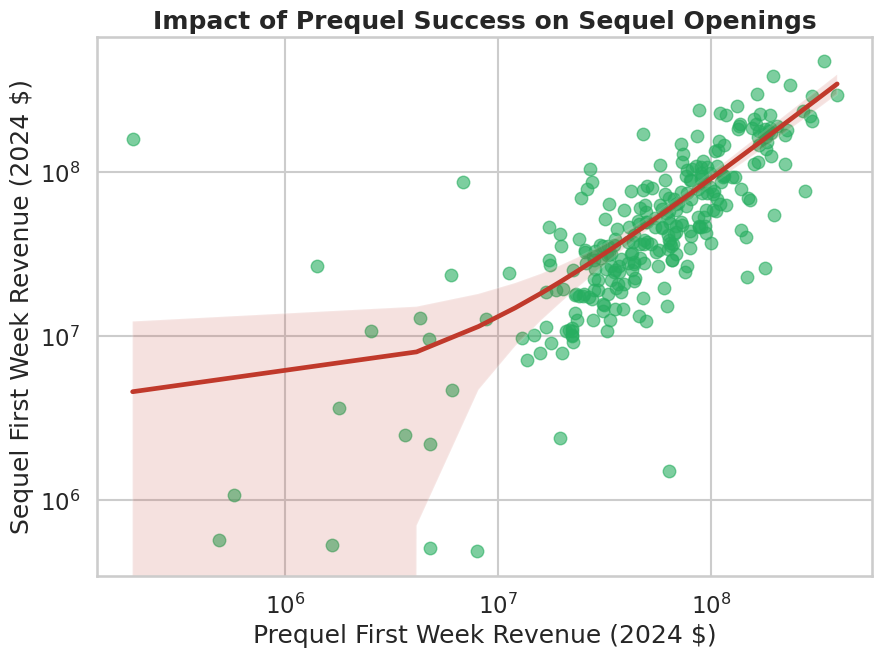

In [90]:
# VISUALIZATION
plt.figure(figsize=(10, 7))
sns.set(style="whitegrid", context="talk")

# Regression Plot
# We use log-log scale because box office data is exponential
sns.regplot(
    x='prequel_revenue',
    y='first_week_revenue',
    data=sequels_only,
    scatter_kws={'alpha': 0.6, 'color': '#27ae60'}, # Green dots
    line_kws={'color': '#c0392b'} # Red line
)

plt.title('Impact of Prequel Success on Sequel Openings', weight='bold')
plt.xlabel('Prequel First Week Revenue (2024 $)')
plt.ylabel('Sequel First Week Revenue (2024 $)')

# Set Log Scale
plt.xscale('log')
plt.yscale('log')

The incredibly high correlation between prequel revenue and sequel revenue. However, a major caveat of the prequel_revenue feature is that the model thinks that movies with no prequels actually had a prequel which made 0 revenue. This is a faulty assumption. We will keep this feature for now and test it out in our model to see if the data actually improves model performance.

### Sequel Number

The serial of the sequel captures how mature the movie is in the market

In [91]:
# Add franchise position feature
df_features = df_features.sort_values(['collection_id', 'release_date'])
df_features['franchise_position'] = df_features.groupby('collection_id').cumcount() + 1

# Cap at 10 to avoid outliers (Fast & Furious has 10+ movies)
df_features['franchise_position'] = df_features['franchise_position'].clip(upper=10)

# For non-franchise movies, set to 0
df_features.loc[df_features['collection_id'].isna(), 'franchise_position'] = 0

### Years Since Last Installment

This features captures the anticipation behind movies based on how long people had to wait between releases.

In [92]:
# Sort to calculate the feature
df_features = df_features.sort_values(by=['collection_id', 'release_date'])
df_features['days_since_last'] = df_features.groupby('collection_id')['release_date'].diff().dt.days
df_features['years_since_last_installment'] = df_features['days_since_last'] / 365.25
df_features['years_since_last_installment'] = df_features['years_since_last_installment'].fillna(0)

# Drop helper columns
df_features = df_features.drop(columns=['days_since_last'])

## Keywords

This feature specifically captures superhero films based on comic books and graphic novels. These films have often been major hits in the past. This alongside other features will capture how people felt about superhero films over the years. We also confirmed from the The Numbers website that superhero films have seen the highest average gross revenue over the last 30 years.

In [93]:
df_features['keywords']

,keywords
606,"android, spacecraft, space opera, absurd"
650,"bunker, space battle, defeat, failure, sequel"
651,space opera
949,"melancholy, treasure hunt, ancient rome, seque..."
295,"airplane, fight, burglar, hostage, secret iden..."
...,...
1663,"angel, contemporary fantasy, baffled"
1687,"regret, fight, identity, supernatural, manipul..."
1712,"high school, based on novel or book, aunt niec..."
1690,"depression, based on novel or book, biography,..."


In [94]:
# Define the "Comic/Superhero" Keywords
comic_keywords = [
    'based on comic', 'graphic novel', 'superhero', 'marvel', 'dc comics',
    'dark horse', 'image comics', 'comic book', 'comics',
    'based on manga', 'stan lee', 'comic', 'super hero'
]

# Function to check for these keywords
def is_comic_movie(keywords_str):
    if pd.isna(keywords_str): return 0
    # Convert to lowercase for easy matching
    kw_lower = str(keywords_str).lower()

    for phrase in comic_keywords:
        if phrase in kw_lower:
            return 1 # Found a match!
    return 0

# Apply to DataFrame
print("Flagging Comic Book movies...")
df_features['Source_Comic_Graphic_Novel'] = df_features['keywords'].apply(is_comic_movie)

# Check the results
print(f"Total Comic Book Movies Found: {df_features['Source_Comic_Graphic_Novel'].sum()}")

Flagging Comic Book movies...
Total Comic Book Movies Found: 118


## Interaction Features

Even though the raw components are present, we make these features to capture the non-linear multiplicative effect. For example: A movie with a 200M Budget released on 100 screens (high ratio, low screens) is a completely different market signal (niche, targeted launch) than a movie with a 200M Budget released on 4,000 screens (low ratio, mass launch)

In [95]:
# Budget Efficiency (Budget per Theater)
# Avoid division by zero just in case there are 0 values
df_features['budget_per_theater'] = df_features['budget'] / df_features['Theaters'].replace(0, 1)

Sanity Check

In [96]:
avatar_films = df_features[df_features['primaryTitle'].str.contains('Avatar', case=False, na=False)]
display(avatar_films[['primaryTitle', 'year', 'has_prequel', 'years_since_last_installment', 'first_week_revenue']])

,primaryTitle,year,has_prequel,years_since_last_installment,first_week_revenue
107,Avatar,2009,0,0.00000,137094051
457,Avatar: The Way of Water,2022,1,12.99384,197681686


## Macro Factors

Movie ticket prices have changed our the year, so has consumer attitude towards consuming films. We will now attempt to capture these Macro trends. We will also try inflating our budget and revenue values in the modeling section to see if it improves model performance.

### Average Ticket Price

We collect average ticket prices over the years from The Numbers website and create a feature that captures the changes in ticket prices for the last 16 years. The website doesn't allow scraping so I used the values manually.

[Data Source](https://www.the-numbers.com/market/)

In [97]:
# Average Ticket Price (Source: The Numbers)
atp_map = {
    2008: 7.18, 2009: 7.50,
    2010: 7.89, 2011: 7.93, 2012: 7.96, 2013: 8.13, 2014: 8.17,
    2015: 8.43, 2016: 8.65, 2017: 8.97, 2018: 9.11, 2019: 9.16,
    2020: 9.18, 2021: 10.17, 2022: 10.53, 2023: 10.94, 2024: 11.31, 2025: 11.31
}

def get_ticket_price(year):
    # Default to 2025 price if year is in the future
    return atp_map.get(year, 11.75)

# 'avg_ticket_price' feature
df_features['avg_ticket_price'] = df_features['year'].apply(get_ticket_price)

In [98]:
avatar_films = df_features[df_features['primaryTitle'].str.contains('Avatar', case=False, na=False)]
display(avatar_films[['primaryTitle', 'year', 'avg_ticket_price', 'years_since_last_installment']])

,primaryTitle,year,avg_ticket_price,years_since_last_installment
107,Avatar,2009,7.50,0.00000
457,Avatar: The Way of Water,2022,10.53,12.99384


### CCI

We are using US Consumer Sentiment (University of Michigan) annual averages, which is a very strong proxy for "willingness to spend."

[Data Source](https://www.sca.isr.umich.edu/files/tbyics.pdf)

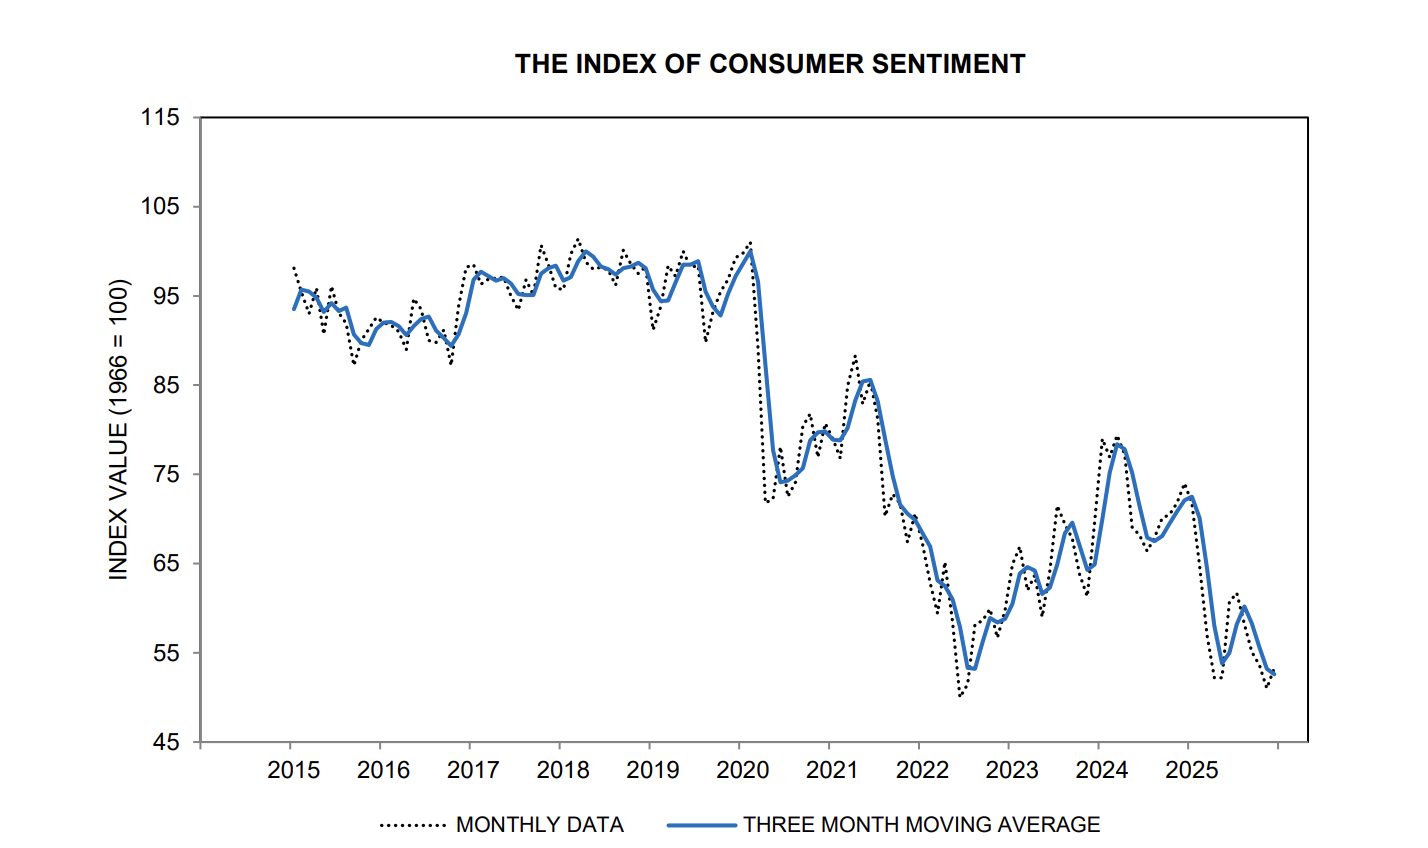

Consumer sentiment to spend has seen strong fluctutations since covid and we still have not reached pre covid levels. Our next feature captures this trend.

In [99]:
# US Consumer Sentiment Index (Annual Average)
# Source: Univ. of Michigan Surveys of Consumers
# > 100 = Optimistic, < 70 = Pessimistic/Recession
sentiment_map = {
    2008: 63.7, 2009: 66.3,
    2010: 71.8, 2011: 67.3, 2012: 76.6, 2013: 79.2, 2014: 84.1,
    2015: 92.9, 2016: 91.9, 2017: 96.8, 2018: 98.4, 2019: 96.0,
    2020: 81.6, 2021: 77.6, 2022: 59.0, 2023: 65.3, 2024: 72.5,
    2025: 58.0
}

def get_sentiment(year):
    return sentiment_map.get(year, 85.0) # Default to average

df_features['consumer_sentiment'] = df_features['year'].apply(get_sentiment)

In [100]:
avatar_films = df_features[df_features['primaryTitle'].str.contains('Avatar', case=False, na=False)]
display(avatar_films[['primaryTitle', 'year', 'avg_ticket_price', 'consumer_sentiment']])

,primaryTitle,year,avg_ticket_price,consumer_sentiment
107,Avatar,2009,7.50,66.3
457,Avatar: The Way of Water,2022,10.53,59.0


## Saving the DataFrame

In [101]:
df_features.to_csv('df_features_final.csv', index=False)

In [102]:
df_features.shape

(1713, 65)

In [103]:
df_features.columns

Index(['imdb_id', 'budget', 'mpaa_rating', 'collection_name', 'collection_id',
       'keywords', 'production_companies', 'main_production_company',
       'director', 'director_id', 'director_popularity', 'top_cast',
       'main_actor_name', 'main_actor_id', 'main_actor_popularity',
       'cast_popularity_sum', 'primaryTitle', 'first_week_revenue',
       'Distributor', 'runtimeMinutes', 'genres', 'Theaters', 'release_date',
       'year', 'is_major_holiday', 'month_August', 'month_December',
       'month_February', 'month_January', 'month_July', 'month_June',
       'month_March', 'month_May', 'month_November', 'month_October',
       'month_September', 'day_Monday', 'day_Saturday', 'day_Sunday',
       'day_Thursday', 'day_Tuesday', 'day_Wednesday', 'competition_count',
       'director_bankability', 'actor_bankability', 'director_experience',
       'is_covid_period', 'dist_cat_Medium', 'dist_cat_Small',
       'distributor_bankability', 'mpaa_rank', 'has_top_yield_genre',
     

# Summary of the Engineered Features

A high level overview of the features we created so far is attached below

**Feature engineering** (Details in the codebook)

* **Holidays**: I looked for major holidays and how they affect revenue. I created a major holiday flag which identifies the movie as a major holiday film if there is a major holiday within first 7 days of airing.

* **Seasonality**: Different months bring different levels of revenue. Made a feature to capture that.

* **Release Year**: This captures macro factors that help the model understand changes over the year.

* **Competition:** How many competing films were released within 7 days of release of any film.

* **Sequel:** Made features that capture whether the movie is a sequel or not. I made an additional feature that captures the serial of the feature and another one that captures the revenue of the prequel.

* **Bankability of Actors and Directors:** Since star power of tmdb had data leakage, I used the data I have to calculate bankability of actors and directors based on how much previous movies they starred in made.

* **Feature for Covid dip:** This captures the low revenue issue during covid

* **Distributor tier and bankability:** This shows how big the distributors are (Based on how many movies they release) and how successful their movies are (bankability).

* **MPAA rating:** The total potential audience size varies according to this so we included this as well.

* **Genres:** As there are many genres and we wanted to avoid curse of dimensionality, we created genre tiers based on how well different genres perform. Then we used multilabel binarizer as a single movie can have multiple genres.

* **Budget tier:** Captures how big the production budget is and helps the model grasp the scale of movies in tiers.

* **Interaction features:** We tried to capture the non-linear multiplicative effect. For example: A movie with a 200M Budget released on 100 screens (high ratio, low screens) is a completely different market signal (niche, targeted launch) than a movie with a 200M Budget released on 4,000 screens.